In [122]:
import os
import time
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
from pytorch_fid import fid_score
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

# ---------------------------
# Matching your constants
# ---------------------------
GENERATE_RES = 3              # Factor (1=32, 2=64, 3=96, etc.)
GENERATE_SQUARE = 32 * GENERATE_RES
IMAGE_CHANNELS = 3

PREVIEW_ROWS = 4
PREVIEW_COLS = 7
PREVIEW_MARGIN = 16

SEED_SIZE = 100
DATA_PATH = "images"
EPOCHS = 800
BATCH_SIZE = 32
BUFFER_SIZE = 60000  # Not strictly used the same in PyTorch, but we'll keep the naming

print(f"Will generate {GENERATE_SQUARE}px square images.")


Will generate 96px square images.


# Dataset

In [123]:
class CustomImageDataset(Dataset):
    def __init__(self, root_dir, image_size=96):
        super().__init__()
        self.root_dir = root_dir
        self.file_list = os.listdir(root_dir)
        
        # Transform to replicate your "divide by 127.5 and subtract 1" 
        self.transform = transforms.Compose([
            transforms.Resize((image_size, image_size), interpolation=transforms.InterpolationMode.LANCZOS),
            transforms.ToTensor(),
            transforms.Normalize([0.5]*3, [0.5]*3)  # scale to [-1, 1]
        ])

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.file_list[idx])
        img = Image.open(img_path).convert("RGB")
        img = self.transform(img)
        return img

# Create dataset & dataloader
dataset = CustomImageDataset(root_dir=DATA_PATH, image_size=GENERATE_SQUARE)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)


# generator

In [124]:
class Generator(nn.Module):
    def __init__(self, seed_size=100, channels=3):
        super().__init__()
        self.seed_size = seed_size
        
        # You started with a Dense(4*4*256) => reshape => upsample
        # We'll do that with ConvTranspose2d
        self.net = nn.Sequential(
            # Input: Z latent vector of shape [N, seed_size]
            nn.Linear(seed_size, 4 * 4 * 256),
            nn.ReLU(True),
            nn.Unflatten(dim=1, unflattened_size=(256, 4, 4)),  # shape: [N, 256, 4, 4]
            
            # Upsample #1
            nn.ConvTranspose2d(256, 256, kernel_size=4, stride=2, padding=1, output_padding=0),  
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            
            # Upsample #2
            nn.ConvTranspose2d(256, 256, kernel_size=4, stride=2, padding=1), 
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            
            # Upsample #3
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
        )
        
        # If GENERATE_RES > 1, we do another "upsample" 
        # or we can adapt final conv to produce the correct size
        # For demonstration, let's always assume we need one more upsample
        if GENERATE_RES > 1:
            self.extra_upsample = nn.Sequential(
                nn.ConvTranspose2d(128, 128, kernel_size=GENERATE_RES, stride=GENERATE_RES, padding=0),
                nn.BatchNorm2d(128),
                nn.ReLU(True),
            )
        else:
            self.extra_upsample = nn.Identity()
        
        # Final output
        self.final = nn.Sequential(
            nn.Conv2d(128, channels, kernel_size=3, stride=1, padding=1),
            nn.Tanh()  # scale to [-1,1]
        )

    def forward(self, z):
        x = self.net(z)
        x = self.extra_upsample(x)
        x = self.final(x)
        return x


# Instantiate Generator
generator = Generator(seed_size=SEED_SIZE, channels=IMAGE_CHANNELS)

class Discriminator(nn.Module):
    def __init__(self, image_shape):
        super().__init__()
        c, h, w = image_shape

        self.conv_layers = nn.Sequential(
            nn.Conv2d(c, 32, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.25),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ZeroPad2d((0, 1, 0, 1)),  # This adds extra rows/cols
            nn.BatchNorm2d(64, momentum=0.8),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.25),
            
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128, momentum=0.8),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.25),
            
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256, momentum=0.8),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.25),
            
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512, momentum=0.8),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.25),
        )

        # Compute flattened size dynamically using a dummy input:
        with torch.no_grad():
            dummy = torch.zeros(1, c, h, w)
            dummy_out = self.conv_layers(dummy)
            self.flattened_size = dummy_out.view(1, -1).size(1)
            print("Flattened size:", self.flattened_size)

        self.fc = nn.Linear(self.flattened_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = self.sigmoid(x)
        return x

# Instantiate with image shape (channels, height, width)
disc_img_shape = (IMAGE_CHANNELS, GENERATE_SQUARE, GENERATE_SQUARE)
discriminator = Discriminator(disc_img_shape)


Flattened size: 86528


In [125]:
criterion = nn.BCELoss()

lr = 1.5e-4
beta1 = 0.5

generator_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))


In [126]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator.to(device)
discriminator.to(device)

def train_step(real_images):
    # real_images: [BATCH_SIZE, 3, H, W]
    real_images = real_images.to(device)

    batch_size = real_images.size(0)

    # Labels
    real_labels = torch.ones(batch_size, 1, device=device)
    fake_labels = torch.zeros(batch_size, 1, device=device)

    # 1. Train Discriminator
    discriminator_optimizer.zero_grad()

    # Real images loss
    real_outputs = discriminator(real_images)
    d_real_loss = criterion(real_outputs, real_labels)

    # Fake images
    noise = torch.randn(batch_size, SEED_SIZE, device=device)
    fake_images = generator(noise)
    fake_outputs = discriminator(fake_images.detach())  # detach so G isn't updated here
    d_fake_loss = criterion(fake_outputs, fake_labels)

    d_loss = d_real_loss + d_fake_loss
    d_loss.backward()
    discriminator_optimizer.step()

    # 2. Train Generator
    generator_optimizer.zero_grad()

    # We want the discriminator to think these fakes are real
    fake_outputs = discriminator(fake_images)  # no detach, so gradients flow to G
    g_loss = criterion(fake_outputs, real_labels)
    g_loss.backward()
    generator_optimizer.step()

    return g_loss.item(), d_loss.item()


In [127]:
def save_images(epoch, fixed_noise, rows=4, cols=7, margin=16):
    # Generate
    with torch.no_grad():
        fake = generator(fixed_noise).detach().cpu()

    # Rescale from [-1,1] to [0,1]
    fake = (fake + 1) * 0.5  
    # shape: [N, 3, H, W]

    # Create a large canvas
    height = margin + (rows * (GENERATE_SQUARE + margin))
    width = margin + (cols * (GENERATE_SQUARE + margin))
    image_array = np.full((height, width, 3), 255, dtype=np.uint8)

    idx = 0
    for r in range(rows):
        for c in range(cols):
            if idx >= fake.size(0):
                break
            start_y = r * (GENERATE_SQUARE + margin) + margin
            start_x = c * (GENERATE_SQUARE + margin) + margin
            img = fake[idx].permute(1,2,0).numpy()  # shape: [H, W, 3]
            img = np.clip(img * 255, 0, 255).astype(np.uint8)
            image_array[start_y:start_y+GENERATE_SQUARE,
                        start_x:start_x+GENERATE_SQUARE] = img
            idx += 1

    # Save
    output_path = os.path.join(DATA_PATH, "output2 ")
    os.makedirs(output_path, exist_ok=True)
    out_filename = os.path.join(output_path, f"train-{epoch}.png")

    pil_img = Image.fromarray(image_array)
    pil_img.save(out_filename)
    print(f"Saved {out_filename}")


In [128]:
all_g_losses = []
all_d_losses = []
fid_scores = [] 
def train_gan(epochs, dataloader):
    # fixed noise for preview
    fixed_noise = torch.randn(PREVIEW_ROWS*PREVIEW_COLS, SEED_SIZE, device=device)

    start_time = time.time()
    for epoch in range(epochs):
        epoch_start = time.time()
        g_losses = []
        d_losses = []

        for real_batch in tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}", leave=False):
            g_loss, d_loss = train_step(real_batch)
            g_losses.append(g_loss)
            d_losses.append(d_loss)

        g_mean = sum(g_losses) / len(g_losses)
        d_mean = sum(d_losses) / len(d_losses)
        all_g_losses.append(g_mean)
        all_d_losses.append(d_mean)
        epoch_elapsed = time.time() - epoch_start
        print(f"Epoch [{epoch+1}/{epochs}]  G_loss: {g_mean:.4f}, D_loss: {d_mean:.4f}, time: {epoch_elapsed:.2f}s")

        # Save sample images
        save_images(epoch, fixed_noise, rows=PREVIEW_ROWS, cols=PREVIEW_COLS, margin=PREVIEW_MARGIN)


        if (epoch + 1) % 5 == 0:
            fid_generated_folder = os.path.join(DATA_PATH, "fid_generated")
            fid_real_folder = os.path.join(DATA_PATH, "fid_real")
            os.makedirs(fid_generated_folder, exist_ok=True)
            os.makedirs(fid_real_folder, exist_ok=True)
            
            # Generate 30 fake images
            noise = torch.randn(30, SEED_SIZE, device=device)
            with torch.no_grad():
                fake_imgs = generator(noise).detach().cpu()  # shape: [30, C, H, W]
            for i in range(30):
                img = fake_imgs[i]
                img = (img + 1) * 0.5  # scale to [0,1]
                img = img.clamp(0,1).numpy()
                img = np.transpose(img, (1,2,0))  # convert to HWC
                img = (img * 255).astype(np.uint8)
                Image.fromarray(img).save(os.path.join(fid_generated_folder, f"fake_{epoch+1}_{i}.png"))
            
            # Sample 30 real images randomly from the dataset
            for i in range(30):
                idx = np.random.randint(0, len(dataset))
                real_img = dataset[idx].numpy()  # shape: (C, H, W) in [-1,1]
                real_img = (real_img + 1) * 0.5  # scale to [0,1]
                real_img = np.transpose(real_img, (1,2,0))
                real_img = (real_img * 255).astype(np.uint8)
                Image.fromarray(real_img).save(os.path.join(fid_real_folder, f"real_{epoch+1}_{i}.png"))
            
            # Compute FID score
            # Use device.type to provide either 'cuda' or 'cpu'
            fid_value = fid_score.calculate_fid_given_paths(
                [fid_real_folder, fid_generated_folder],
                batch_size=30, device=device.type, dims=2048
            )
            fid_scores.append((epoch+1, fid_value))
            print(f"Epoch [{epoch+1}]: FID = {fid_value:.2f}")
    
    total_time = time.time() - start_time
    print(f"Training complete. Total time: {total_time:.2f}s")

# Start training


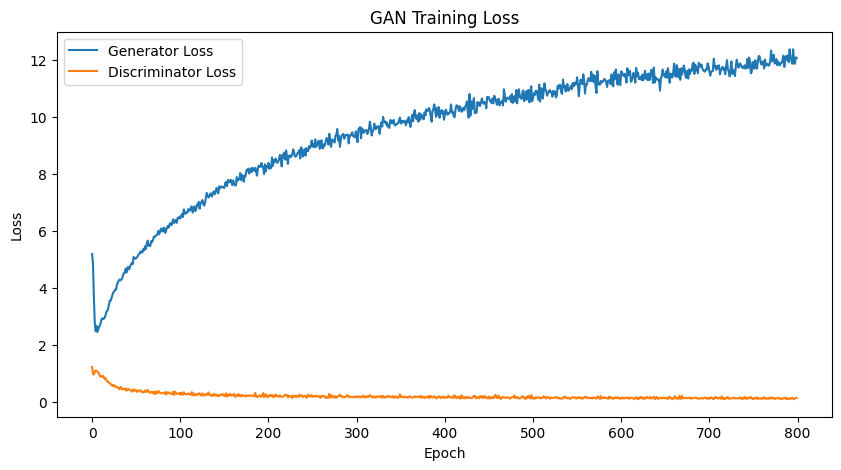

In [132]:
plt.figure(figsize=(10, 5))
plt.plot(all_g_losses, label="Generator Loss")
plt.plot(all_d_losses, label="Discriminator Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("GAN Training Loss")
plt.legend()
plt.show()

Epoch [1/800]  G_loss: 5.1936, D_loss: 1.2284, time: 14.36s
Saved images\output2 \train-0.png


Epoch [2/800]  G_loss: 4.8357, D_loss: 0.9852, time: 13.84s
Saved images\output2 \train-1.png


Epoch [3/800]  G_loss: 3.6525, D_loss: 0.9612, time: 14.09s
Saved images\output2 \train-2.png


Epoch [4/800]  G_loss: 2.7666, D_loss: 1.0509, time: 13.76s
Saved images\output2 \train-3.png


Epoch [5/800]  G_loss: 2.4832, D_loss: 1.1031, time: 13.67s
Saved images\output2 \train-4.png


100%|██████████| 1/1 [00:02<00:00,  2.28s/it]


Epoch [5]: FID = 412.10


Epoch [6/800]  G_loss: 2.6655, D_loss: 1.0863, time: 13.85s
Saved images\output2 \train-5.png


Epoch [7/800]  G_loss: 2.4524, D_loss: 1.0591, time: 13.89s
Saved images\output2 \train-6.png


Epoch [8/800]  G_loss: 2.5426, D_loss: 1.0243, time: 13.75s
Saved images\output2 \train-7.png


Epoch [9/800]  G_loss: 2.6418, D_loss: 0.9869, time: 13.75s
Saved images\output2 \train-8.png


Epoch [10/800]  G_loss: 2.7007, D_loss: 0.8939, time: 14.08s
Saved images\output2 \train-9.png


100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


Epoch [10]: FID = 387.56


Epoch [11/800]  G_loss: 2.8197, D_loss: 0.8908, time: 12.95s
Saved images\output2 \train-10.png


Epoch [12/800]  G_loss: 2.9238, D_loss: 0.8773, time: 12.86s
Saved images\output2 \train-11.png


Epoch [13/800]  G_loss: 2.9268, D_loss: 0.9159, time: 12.85s
Saved images\output2 \train-12.png


Epoch [14/800]  G_loss: 2.9122, D_loss: 0.8741, time: 12.86s
Saved images\output2 \train-13.png


Epoch [15/800]  G_loss: 2.9480, D_loss: 0.8095, time: 12.85s
Saved images\output2 \train-14.png


100%|██████████| 3/3 [00:02<00:00,  1.33it/s]


Epoch [15]: FID = 369.14


Epoch [16/800]  G_loss: 3.0203, D_loss: 0.8410, time: 13.15s
Saved images\output2 \train-15.png


Epoch [17/800]  G_loss: 3.1462, D_loss: 0.7646, time: 12.85s
Saved images\output2 \train-16.png


Epoch [18/800]  G_loss: 3.1978, D_loss: 0.7387, time: 12.83s
Saved images\output2 \train-17.png


Epoch [19/800]  G_loss: 3.2480, D_loss: 0.6866, time: 12.86s
Saved images\output2 \train-18.png


Epoch [20/800]  G_loss: 3.4005, D_loss: 0.6811, time: 12.83s
Saved images\output2 \train-19.png


100%|██████████| 4/4 [00:02<00:00,  1.78it/s]


Epoch [20]: FID = 349.35


Epoch [21/800]  G_loss: 3.5567, D_loss: 0.6662, time: 13.24s
Saved images\output2 \train-20.png


Epoch [22/800]  G_loss: 3.5525, D_loss: 0.6181, time: 12.98s
Saved images\output2 \train-21.png


Epoch [23/800]  G_loss: 3.6516, D_loss: 0.5977, time: 13.00s
Saved images\output2 \train-22.png


Epoch [24/800]  G_loss: 3.7555, D_loss: 0.5568, time: 12.85s
Saved images\output2 \train-23.png


Epoch [25/800]  G_loss: 3.8475, D_loss: 0.5983, time: 12.82s
Saved images\output2 \train-24.png


100%|██████████| 5/5 [00:02<00:00,  2.18it/s]


Epoch [25]: FID = 316.30


Epoch [26/800]  G_loss: 3.8763, D_loss: 0.5555, time: 13.15s
Saved images\output2 \train-25.png


Epoch [27/800]  G_loss: 3.9384, D_loss: 0.5672, time: 13.80s
Saved images\output2 \train-26.png


Epoch [28/800]  G_loss: 3.9354, D_loss: 0.5123, time: 14.73s
Saved images\output2 \train-27.png


Epoch [29/800]  G_loss: 4.0861, D_loss: 0.5315, time: 13.04s
Saved images\output2 \train-28.png


Epoch [30/800]  G_loss: 4.1872, D_loss: 0.4982, time: 13.01s
Saved images\output2 \train-29.png


100%|██████████| 6/6 [00:02<00:00,  2.35it/s]


Epoch [30]: FID = 291.77


Epoch [31/800]  G_loss: 4.2490, D_loss: 0.4906, time: 40.37s
Saved images\output2 \train-30.png


Epoch [32/800]  G_loss: 4.2980, D_loss: 0.4436, time: 13.02s
Saved images\output2 \train-31.png


Epoch [33/800]  G_loss: 4.2653, D_loss: 0.5055, time: 12.85s
Saved images\output2 \train-32.png


Epoch [34/800]  G_loss: 4.2953, D_loss: 0.5230, time: 12.84s
Saved images\output2 \train-33.png


Epoch [35/800]  G_loss: 4.3267, D_loss: 0.4427, time: 12.85s
Saved images\output2 \train-34.png


100%|██████████| 7/7 [00:02<00:00,  2.99it/s]


Epoch [35]: FID = 273.47


Epoch [36/800]  G_loss: 4.4547, D_loss: 0.4389, time: 12.96s
Saved images\output2 \train-35.png


Epoch [37/800]  G_loss: 4.5199, D_loss: 0.4522, time: 12.84s
Saved images\output2 \train-36.png


Epoch [38/800]  G_loss: 4.5339, D_loss: 0.4418, time: 12.83s
Saved images\output2 \train-37.png


Epoch [39/800]  G_loss: 4.6733, D_loss: 0.4783, time: 12.88s
Saved images\output2 \train-38.png


Epoch [40/800]  G_loss: 4.5431, D_loss: 0.3930, time: 12.87s
Saved images\output2 \train-39.png


100%|██████████| 8/8 [00:02<00:00,  3.41it/s]


Epoch [40]: FID = 259.19


Epoch [41/800]  G_loss: 4.7252, D_loss: 0.4334, time: 12.98s
Saved images\output2 \train-40.png


Epoch [42/800]  G_loss: 4.7338, D_loss: 0.4512, time: 12.85s
Saved images\output2 \train-41.png


Epoch [43/800]  G_loss: 4.6537, D_loss: 0.4272, time: 12.86s
Saved images\output2 \train-42.png


Epoch [44/800]  G_loss: 4.7610, D_loss: 0.4265, time: 12.85s
Saved images\output2 \train-43.png


Epoch [45/800]  G_loss: 4.8155, D_loss: 0.4060, time: 12.85s
Saved images\output2 \train-44.png


100%|██████████| 9/9 [00:02<00:00,  3.81it/s]


Epoch [45]: FID = 243.05


Epoch [46/800]  G_loss: 4.8823, D_loss: 0.3685, time: 13.14s
Saved images\output2 \train-45.png


Epoch [47/800]  G_loss: 4.8397, D_loss: 0.3614, time: 12.85s
Saved images\output2 \train-46.png


Epoch [48/800]  G_loss: 5.0874, D_loss: 0.4436, time: 12.84s
Saved images\output2 \train-47.png


Epoch [49/800]  G_loss: 5.0636, D_loss: 0.3961, time: 12.85s
Saved images\output2 \train-48.png


Epoch [50/800]  G_loss: 5.0290, D_loss: 0.4086, time: 12.85s
Saved images\output2 \train-49.png


100%|██████████| 10/10 [00:02<00:00,  4.02it/s]


Epoch [50]: FID = 231.85


Epoch [51/800]  G_loss: 5.0541, D_loss: 0.4101, time: 13.08s
Saved images\output2 \train-50.png


Epoch [52/800]  G_loss: 5.0757, D_loss: 0.3499, time: 12.85s
Saved images\output2 \train-51.png


Epoch [53/800]  G_loss: 5.1460, D_loss: 0.3832, time: 12.85s
Saved images\output2 \train-52.png


Epoch [54/800]  G_loss: 5.1877, D_loss: 0.4056, time: 12.84s
Saved images\output2 \train-53.png


Epoch [55/800]  G_loss: 5.2154, D_loss: 0.4011, time: 12.84s
Saved images\output2 \train-54.png


100%|██████████| 11/11 [00:02<00:00,  4.38it/s]


Epoch [55]: FID = 219.85


Epoch [56/800]  G_loss: 5.2912, D_loss: 0.3967, time: 13.16s
Saved images\output2 \train-55.png


Epoch [57/800]  G_loss: 5.2433, D_loss: 0.3458, time: 12.84s
Saved images\output2 \train-56.png


Epoch [58/800]  G_loss: 5.2536, D_loss: 0.3644, time: 12.85s
Saved images\output2 \train-57.png


Epoch [59/800]  G_loss: 5.3654, D_loss: 0.3330, time: 12.85s
Saved images\output2 \train-58.png


Epoch [60/800]  G_loss: 5.3205, D_loss: 0.3490, time: 12.85s
Saved images\output2 \train-59.png


100%|██████████| 12/12 [00:02<00:00,  4.71it/s]


Epoch [60]: FID = 212.61


Epoch [61/800]  G_loss: 5.4633, D_loss: 0.4052, time: 13.01s
Saved images\output2 \train-60.png


Epoch [62/800]  G_loss: 5.3710, D_loss: 0.3509, time: 12.82s
Saved images\output2 \train-61.png


Epoch [63/800]  G_loss: 5.5594, D_loss: 0.3561, time: 12.84s
Saved images\output2 \train-62.png


Epoch [64/800]  G_loss: 5.6651, D_loss: 0.4233, time: 12.85s
Saved images\output2 \train-63.png


Epoch [65/800]  G_loss: 5.4782, D_loss: 0.3577, time: 12.85s
Saved images\output2 \train-64.png


100%|██████████| 13/13 [00:02<00:00,  5.04it/s]


Epoch [65]: FID = 204.79


Epoch [66/800]  G_loss: 5.5175, D_loss: 0.3343, time: 13.23s
Saved images\output2 \train-65.png


Epoch [67/800]  G_loss: 5.4805, D_loss: 0.3179, time: 12.94s
Saved images\output2 \train-66.png


Epoch [68/800]  G_loss: 5.6446, D_loss: 0.3479, time: 12.86s
Saved images\output2 \train-67.png


Epoch [69/800]  G_loss: 5.6170, D_loss: 0.3477, time: 12.82s
Saved images\output2 \train-68.png


Epoch [70/800]  G_loss: 5.6807, D_loss: 0.3019, time: 12.84s
Saved images\output2 \train-69.png


100%|██████████| 14/14 [00:02<00:00,  5.47it/s]


Epoch [70]: FID = 197.82


Epoch [71/800]  G_loss: 5.8010, D_loss: 0.3476, time: 13.00s
Saved images\output2 \train-70.png


Epoch [72/800]  G_loss: 5.7900, D_loss: 0.2686, time: 12.86s
Saved images\output2 \train-71.png


Epoch [73/800]  G_loss: 5.8425, D_loss: 0.3663, time: 12.83s
Saved images\output2 \train-72.png


Epoch [74/800]  G_loss: 5.8556, D_loss: 0.2974, time: 12.83s
Saved images\output2 \train-73.png


Epoch [75/800]  G_loss: 5.8700, D_loss: 0.3005, time: 12.82s
Saved images\output2 \train-74.png


100%|██████████| 15/15 [00:02<00:00,  5.83it/s]


Epoch [75]: FID = 192.29


Epoch [76/800]  G_loss: 6.0062, D_loss: 0.3848, time: 13.06s
Saved images\output2 \train-75.png


Epoch [77/800]  G_loss: 5.8880, D_loss: 0.3306, time: 12.88s
Saved images\output2 \train-76.png


Epoch [78/800]  G_loss: 5.9662, D_loss: 0.3139, time: 12.86s
Saved images\output2 \train-77.png


Epoch [79/800]  G_loss: 6.0870, D_loss: 0.3026, time: 12.84s
Saved images\output2 \train-78.png


Epoch [80/800]  G_loss: 6.0482, D_loss: 0.3028, time: 12.84s
Saved images\output2 \train-79.png


100%|██████████| 16/16 [00:02<00:00,  5.95it/s]


Epoch [80]: FID = 185.04


Epoch [81/800]  G_loss: 5.9782, D_loss: 0.3180, time: 13.04s
Saved images\output2 \train-80.png


Epoch [82/800]  G_loss: 6.1115, D_loss: 0.2939, time: 12.83s
Saved images\output2 \train-81.png


Epoch [83/800]  G_loss: 6.1134, D_loss: 0.2978, time: 12.83s
Saved images\output2 \train-82.png


Epoch [84/800]  G_loss: 5.9318, D_loss: 0.3469, time: 12.92s
Saved images\output2 \train-83.png


Epoch [85/800]  G_loss: 6.0247, D_loss: 0.2561, time: 12.85s
Saved images\output2 \train-84.png


100%|██████████| 17/17 [00:02<00:00,  6.51it/s]


Epoch [85]: FID = 180.29


Epoch [86/800]  G_loss: 6.1199, D_loss: 0.3269, time: 13.00s
Saved images\output2 \train-85.png


Epoch [87/800]  G_loss: 6.1846, D_loss: 0.3372, time: 12.84s
Saved images\output2 \train-86.png


Epoch [88/800]  G_loss: 6.1235, D_loss: 0.3204, time: 12.85s
Saved images\output2 \train-87.png


Epoch [89/800]  G_loss: 6.2532, D_loss: 0.2946, time: 12.82s
Saved images\output2 \train-88.png


Epoch [90/800]  G_loss: 6.2799, D_loss: 0.2955, time: 12.86s
Saved images\output2 \train-89.png


100%|██████████| 18/18 [00:02<00:00,  6.63it/s]


Epoch [90]: FID = 175.50


Epoch [91/800]  G_loss: 6.2109, D_loss: 0.2771, time: 13.04s
Saved images\output2 \train-90.png


Epoch [92/800]  G_loss: 6.3060, D_loss: 0.2770, time: 12.83s
Saved images\output2 \train-91.png


Epoch [93/800]  G_loss: 6.4157, D_loss: 0.3626, time: 12.85s
Saved images\output2 \train-92.png


Epoch [94/800]  G_loss: 6.2824, D_loss: 0.2427, time: 12.88s
Saved images\output2 \train-93.png


Epoch [95/800]  G_loss: 6.3396, D_loss: 0.3554, time: 12.82s
Saved images\output2 \train-94.png


100%|██████████| 19/19 [00:02<00:00,  6.88it/s]


Epoch [95]: FID = 171.49


Epoch [96/800]  G_loss: 6.3916, D_loss: 0.3174, time: 13.04s
Saved images\output2 \train-95.png


Epoch [97/800]  G_loss: 6.2888, D_loss: 0.2773, time: 12.85s
Saved images\output2 \train-96.png


Epoch [98/800]  G_loss: 6.4587, D_loss: 0.2801, time: 12.85s
Saved images\output2 \train-97.png


Epoch [99/800]  G_loss: 6.4524, D_loss: 0.2989, time: 12.85s
Saved images\output2 \train-98.png


Epoch [100/800]  G_loss: 6.5082, D_loss: 0.3083, time: 12.86s
Saved images\output2 \train-99.png


100%|██████████| 20/20 [00:02<00:00,  7.20it/s]


Epoch [100]: FID = 167.42


Epoch [101/800]  G_loss: 6.4412, D_loss: 0.2515, time: 13.17s
Saved images\output2 \train-100.png


Epoch [102/800]  G_loss: 6.5368, D_loss: 0.3275, time: 12.83s
Saved images\output2 \train-101.png


Epoch [103/800]  G_loss: 6.6049, D_loss: 0.2535, time: 12.83s
Saved images\output2 \train-102.png


Epoch [104/800]  G_loss: 6.4914, D_loss: 0.2614, time: 12.85s
Saved images\output2 \train-103.png


Epoch [105/800]  G_loss: 6.7599, D_loss: 0.3366, time: 12.87s
Saved images\output2 \train-104.png


100%|██████████| 21/21 [00:02<00:00,  7.58it/s]


Epoch [105]: FID = 163.04


Epoch [106/800]  G_loss: 6.6202, D_loss: 0.2802, time: 13.06s
Saved images\output2 \train-105.png


Epoch [107/800]  G_loss: 6.6098, D_loss: 0.2677, time: 12.85s
Saved images\output2 \train-106.png


Epoch [108/800]  G_loss: 6.6611, D_loss: 0.2635, time: 12.83s
Saved images\output2 \train-107.png


Epoch [109/800]  G_loss: 6.6470, D_loss: 0.2794, time: 12.85s
Saved images\output2 \train-108.png


Epoch [110/800]  G_loss: 6.7706, D_loss: 0.2968, time: 12.82s
Saved images\output2 \train-109.png


100%|██████████| 22/22 [00:02<00:00,  7.93it/s]


Epoch [110]: FID = 159.92


Epoch [111/800]  G_loss: 6.7309, D_loss: 0.2657, time: 13.14s
Saved images\output2 \train-110.png


Epoch [112/800]  G_loss: 6.7165, D_loss: 0.2797, time: 12.83s
Saved images\output2 \train-111.png


Epoch [113/800]  G_loss: 6.8302, D_loss: 0.2509, time: 12.86s
Saved images\output2 \train-112.png


Epoch [114/800]  G_loss: 6.8658, D_loss: 0.3421, time: 12.86s
Saved images\output2 \train-113.png


Epoch [115/800]  G_loss: 6.6489, D_loss: 0.2396, time: 12.85s
Saved images\output2 \train-114.png


100%|██████████| 23/23 [00:02<00:00,  8.11it/s]


Epoch [115]: FID = 157.14


Epoch [116/800]  G_loss: 6.7617, D_loss: 0.2307, time: 13.12s
Saved images\output2 \train-115.png


Epoch [117/800]  G_loss: 6.8673, D_loss: 0.2937, time: 12.84s
Saved images\output2 \train-116.png


Epoch [118/800]  G_loss: 6.6999, D_loss: 0.2359, time: 12.86s
Saved images\output2 \train-117.png


Epoch [119/800]  G_loss: 6.7759, D_loss: 0.2465, time: 12.86s
Saved images\output2 \train-118.png


Epoch [120/800]  G_loss: 6.9288, D_loss: 0.2661, time: 12.82s
Saved images\output2 \train-119.png


100%|██████████| 24/24 [00:02<00:00,  8.46it/s]


Epoch [120]: FID = 154.93


Epoch [121/800]  G_loss: 6.9061, D_loss: 0.2493, time: 12.94s
Saved images\output2 \train-120.png


Epoch [122/800]  G_loss: 7.0270, D_loss: 0.3004, time: 12.83s
Saved images\output2 \train-121.png


Epoch [123/800]  G_loss: 6.7861, D_loss: 0.2893, time: 12.85s
Saved images\output2 \train-122.png


Epoch [124/800]  G_loss: 6.9915, D_loss: 0.2498, time: 12.84s
Saved images\output2 \train-123.png


Epoch [125/800]  G_loss: 7.0049, D_loss: 0.2125, time: 12.83s
Saved images\output2 \train-124.png


100%|██████████| 25/25 [00:02<00:00,  8.50it/s]


Epoch [125]: FID = 152.67


Epoch [126/800]  G_loss: 7.0900, D_loss: 0.2991, time: 13.04s
Saved images\output2 \train-125.png


Epoch [127/800]  G_loss: 6.9599, D_loss: 0.2382, time: 12.80s
Saved images\output2 \train-126.png


Epoch [128/800]  G_loss: 6.8946, D_loss: 0.2190, time: 12.79s
Saved images\output2 \train-127.png


Epoch [129/800]  G_loss: 6.9770, D_loss: 0.2290, time: 12.81s
Saved images\output2 \train-128.png


Epoch [130/800]  G_loss: 7.1813, D_loss: 0.2784, time: 12.80s
Saved images\output2 \train-129.png


100%|██████████| 26/26 [00:02<00:00,  8.82it/s]


Epoch [130]: FID = 150.21


Epoch [131/800]  G_loss: 7.3396, D_loss: 0.2493, time: 12.93s
Saved images\output2 \train-130.png


Epoch [132/800]  G_loss: 7.2309, D_loss: 0.2491, time: 12.81s
Saved images\output2 \train-131.png


Epoch [133/800]  G_loss: 7.1776, D_loss: 0.3314, time: 12.85s
Saved images\output2 \train-132.png


Epoch [134/800]  G_loss: 7.2203, D_loss: 0.2420, time: 12.81s
Saved images\output2 \train-133.png


Epoch [135/800]  G_loss: 7.3236, D_loss: 0.2226, time: 12.83s
Saved images\output2 \train-134.png


100%|██████████| 27/27 [00:02<00:00,  9.10it/s]


Epoch [135]: FID = 147.48


Epoch [136/800]  G_loss: 7.3120, D_loss: 0.2555, time: 12.98s
Saved images\output2 \train-135.png


Epoch [137/800]  G_loss: 7.2109, D_loss: 0.2117, time: 12.84s
Saved images\output2 \train-136.png


Epoch [138/800]  G_loss: 7.3465, D_loss: 0.2082, time: 12.81s
Saved images\output2 \train-137.png


Epoch [139/800]  G_loss: 7.3968, D_loss: 0.2807, time: 12.84s
Saved images\output2 \train-138.png


Epoch [140/800]  G_loss: 7.2898, D_loss: 0.2644, time: 12.81s
Saved images\output2 \train-139.png


100%|██████████| 28/28 [00:02<00:00,  9.44it/s]


Epoch [140]: FID = 144.92


Epoch [141/800]  G_loss: 7.3761, D_loss: 0.2189, time: 13.11s
Saved images\output2 \train-140.png


Epoch [142/800]  G_loss: 7.5118, D_loss: 0.2542, time: 12.83s
Saved images\output2 \train-141.png


Epoch [143/800]  G_loss: 7.4738, D_loss: 0.2129, time: 12.84s
Saved images\output2 \train-142.png


Epoch [144/800]  G_loss: 7.3256, D_loss: 0.2311, time: 12.85s
Saved images\output2 \train-143.png


Epoch [145/800]  G_loss: 7.5692, D_loss: 0.2060, time: 12.88s
Saved images\output2 \train-144.png


100%|██████████| 29/29 [00:02<00:00,  9.69it/s]


Epoch [145]: FID = 143.26


Epoch [146/800]  G_loss: 7.4963, D_loss: 0.2435, time: 13.10s
Saved images\output2 \train-145.png


Epoch [147/800]  G_loss: 7.5648, D_loss: 0.2367, time: 12.80s
Saved images\output2 \train-146.png


Epoch [148/800]  G_loss: 7.5642, D_loss: 0.2517, time: 12.81s
Saved images\output2 \train-147.png


Epoch [149/800]  G_loss: 7.5421, D_loss: 0.2764, time: 12.82s
Saved images\output2 \train-148.png


Epoch [150/800]  G_loss: 7.5225, D_loss: 0.2199, time: 12.84s
Saved images\output2 \train-149.png


100%|██████████| 30/30 [00:03<00:00,  9.80it/s]


Epoch [150]: FID = 141.22


Epoch [151/800]  G_loss: 7.5166, D_loss: 0.2362, time: 12.98s
Saved images\output2 \train-150.png


Epoch [152/800]  G_loss: 7.6975, D_loss: 0.2059, time: 12.83s
Saved images\output2 \train-151.png


Epoch [153/800]  G_loss: 7.7266, D_loss: 0.3009, time: 12.84s
Saved images\output2 \train-152.png


Epoch [154/800]  G_loss: 7.5791, D_loss: 0.1883, time: 12.84s
Saved images\output2 \train-153.png


Epoch [155/800]  G_loss: 7.7944, D_loss: 0.2299, time: 12.82s
Saved images\output2 \train-154.png


100%|██████████| 31/31 [00:03<00:00,  9.93it/s]


Epoch [155]: FID = 139.37


Epoch [156/800]  G_loss: 7.7220, D_loss: 0.2152, time: 13.01s
Saved images\output2 \train-155.png


Epoch [157/800]  G_loss: 7.7143, D_loss: 0.2827, time: 12.78s
Saved images\output2 \train-156.png


Epoch [158/800]  G_loss: 7.8057, D_loss: 0.2524, time: 12.83s
Saved images\output2 \train-157.png


Epoch [159/800]  G_loss: 7.7370, D_loss: 0.2173, time: 12.83s
Saved images\output2 \train-158.png


Epoch [160/800]  G_loss: 7.6135, D_loss: 0.2334, time: 12.80s
Saved images\output2 \train-159.png


100%|██████████| 32/32 [00:03<00:00, 10.22it/s]


Epoch [160]: FID = 137.49


Epoch [161/800]  G_loss: 7.7796, D_loss: 0.2374, time: 13.16s
Saved images\output2 \train-160.png


Epoch [162/800]  G_loss: 7.6512, D_loss: 0.2802, time: 12.83s
Saved images\output2 \train-161.png


Epoch [163/800]  G_loss: 7.6050, D_loss: 0.1813, time: 12.84s
Saved images\output2 \train-162.png


Epoch [164/800]  G_loss: 7.6037, D_loss: 0.1950, time: 12.82s
Saved images\output2 \train-163.png


Epoch [165/800]  G_loss: 7.8978, D_loss: 0.2378, time: 12.86s
Saved images\output2 \train-164.png


100%|██████████| 33/33 [00:03<00:00, 10.45it/s]


Epoch [165]: FID = 135.43


Epoch [166/800]  G_loss: 7.7657, D_loss: 0.2124, time: 12.96s
Saved images\output2 \train-165.png


Epoch [167/800]  G_loss: 7.8104, D_loss: 0.2748, time: 12.82s
Saved images\output2 \train-166.png


Epoch [168/800]  G_loss: 7.8351, D_loss: 0.1978, time: 12.83s
Saved images\output2 \train-167.png


Epoch [169/800]  G_loss: 8.0376, D_loss: 0.2376, time: 12.81s
Saved images\output2 \train-168.png


Epoch [170/800]  G_loss: 7.7873, D_loss: 0.1914, time: 12.83s
Saved images\output2 \train-169.png


100%|██████████| 34/34 [00:03<00:00, 10.75it/s]


Epoch [170]: FID = 134.02


Epoch [171/800]  G_loss: 7.9677, D_loss: 0.2367, time: 13.19s
Saved images\output2 \train-170.png


Epoch [172/800]  G_loss: 7.9367, D_loss: 0.2134, time: 12.82s
Saved images\output2 \train-171.png


Epoch [173/800]  G_loss: 7.7305, D_loss: 0.2174, time: 12.83s
Saved images\output2 \train-172.png


Epoch [174/800]  G_loss: 7.9459, D_loss: 0.2173, time: 12.87s
Saved images\output2 \train-173.png


Epoch [175/800]  G_loss: 7.9283, D_loss: 0.1868, time: 12.86s
Saved images\output2 \train-174.png


100%|██████████| 35/35 [00:03<00:00, 11.13it/s]


Epoch [175]: FID = 133.10


Epoch [176/800]  G_loss: 8.1417, D_loss: 0.2311, time: 13.03s
Saved images\output2 \train-175.png


Epoch [177/800]  G_loss: 8.1311, D_loss: 0.2118, time: 12.83s
Saved images\output2 \train-176.png


Epoch [178/800]  G_loss: 8.1964, D_loss: 0.2102, time: 12.84s
Saved images\output2 \train-177.png


Epoch [179/800]  G_loss: 8.0167, D_loss: 0.2276, time: 12.80s
Saved images\output2 \train-178.png


Epoch [180/800]  G_loss: 8.0876, D_loss: 0.2105, time: 12.83s
Saved images\output2 \train-179.png


100%|██████████| 36/36 [00:03<00:00, 10.89it/s]


Epoch [180]: FID = 131.76


Epoch [181/800]  G_loss: 8.2042, D_loss: 0.2083, time: 13.03s
Saved images\output2 \train-180.png


Epoch [182/800]  G_loss: 8.0708, D_loss: 0.2269, time: 12.81s
Saved images\output2 \train-181.png


Epoch [183/800]  G_loss: 8.2240, D_loss: 0.2241, time: 12.82s
Saved images\output2 \train-182.png


Epoch [184/800]  G_loss: 8.1657, D_loss: 0.2110, time: 12.85s
Saved images\output2 \train-183.png


Epoch [185/800]  G_loss: 8.1174, D_loss: 0.1919, time: 12.80s
Saved images\output2 \train-184.png


100%|██████████| 37/37 [00:03<00:00, 11.24it/s]


Epoch [185]: FID = 130.12


Epoch [186/800]  G_loss: 8.2234, D_loss: 0.3145, time: 13.00s
Saved images\output2 \train-185.png


Epoch [187/800]  G_loss: 8.0939, D_loss: 0.1821, time: 12.83s
Saved images\output2 \train-186.png


Epoch [188/800]  G_loss: 7.9476, D_loss: 0.1716, time: 12.81s
Saved images\output2 \train-187.png


Epoch [189/800]  G_loss: 8.2204, D_loss: 0.1986, time: 12.85s
Saved images\output2 \train-188.png


Epoch [190/800]  G_loss: 8.2985, D_loss: 0.1951, time: 12.85s
Saved images\output2 \train-189.png


100%|██████████| 38/38 [00:03<00:00, 11.74it/s]


Epoch [190]: FID = 128.85


Epoch [191/800]  G_loss: 8.2659, D_loss: 0.2314, time: 12.99s
Saved images\output2 \train-190.png


Epoch [192/800]  G_loss: 8.2555, D_loss: 0.1927, time: 12.82s
Saved images\output2 \train-191.png


Epoch [193/800]  G_loss: 8.3898, D_loss: 0.1751, time: 12.81s
Saved images\output2 \train-192.png


Epoch [194/800]  G_loss: 8.2797, D_loss: 0.2556, time: 12.86s
Saved images\output2 \train-193.png


Epoch [195/800]  G_loss: 8.2300, D_loss: 0.3059, time: 12.81s
Saved images\output2 \train-194.png


100%|██████████| 39/39 [00:03<00:00, 11.64it/s]


Epoch [195]: FID = 127.95


Epoch [196/800]  G_loss: 8.0023, D_loss: 0.1623, time: 13.15s
Saved images\output2 \train-195.png


Epoch [197/800]  G_loss: 8.3460, D_loss: 0.2447, time: 12.82s
Saved images\output2 \train-196.png


Epoch [198/800]  G_loss: 8.0949, D_loss: 0.2662, time: 12.88s
Saved images\output2 \train-197.png


Epoch [199/800]  G_loss: 8.2903, D_loss: 0.1895, time: 12.83s
Saved images\output2 \train-198.png


Epoch [200/800]  G_loss: 8.2521, D_loss: 0.1590, time: 12.80s
Saved images\output2 \train-199.png


100%|██████████| 40/40 [00:03<00:00, 11.87it/s]


Epoch [200]: FID = 126.33


Epoch [201/800]  G_loss: 8.3953, D_loss: 0.2245, time: 12.97s
Saved images\output2 \train-200.png


Epoch [202/800]  G_loss: 8.1807, D_loss: 0.2036, time: 12.84s
Saved images\output2 \train-201.png


Epoch [203/800]  G_loss: 8.2832, D_loss: 0.2361, time: 12.82s
Saved images\output2 \train-202.png


Epoch [204/800]  G_loss: 8.2159, D_loss: 0.2034, time: 12.82s
Saved images\output2 \train-203.png


Epoch [205/800]  G_loss: 8.5880, D_loss: 0.2491, time: 12.83s
Saved images\output2 \train-204.png


100%|██████████| 41/41 [00:03<00:00, 12.22it/s]


Epoch [205]: FID = 125.18


Epoch [206/800]  G_loss: 8.2901, D_loss: 0.1720, time: 13.03s
Saved images\output2 \train-205.png


Epoch [207/800]  G_loss: 8.4907, D_loss: 0.1996, time: 12.82s
Saved images\output2 \train-206.png


Epoch [208/800]  G_loss: 8.4217, D_loss: 0.1792, time: 12.81s
Saved images\output2 \train-207.png


Epoch [209/800]  G_loss: 8.5473, D_loss: 0.2617, time: 12.83s
Saved images\output2 \train-208.png


Epoch [210/800]  G_loss: 8.4604, D_loss: 0.1965, time: 12.83s
Saved images\output2 \train-209.png


100%|██████████| 42/42 [00:03<00:00, 12.48it/s]


Epoch [210]: FID = 123.89


Epoch [211/800]  G_loss: 8.3989, D_loss: 0.1954, time: 13.13s
Saved images\output2 \train-210.png


Epoch [212/800]  G_loss: 8.4382, D_loss: 0.2185, time: 12.79s
Saved images\output2 \train-211.png


Epoch [213/800]  G_loss: 8.5282, D_loss: 0.1793, time: 12.81s
Saved images\output2 \train-212.png


Epoch [214/800]  G_loss: 8.6753, D_loss: 0.2327, time: 12.85s
Saved images\output2 \train-213.png


Epoch [215/800]  G_loss: 8.4991, D_loss: 0.1868, time: 12.84s
Saved images\output2 \train-214.png


100%|██████████| 43/43 [00:03<00:00, 12.39it/s]


Epoch [215]: FID = 122.80


Epoch [216/800]  G_loss: 8.2714, D_loss: 0.1837, time: 12.96s
Saved images\output2 \train-215.png


Epoch [217/800]  G_loss: 8.6909, D_loss: 0.1776, time: 12.80s
Saved images\output2 \train-216.png


Epoch [218/800]  G_loss: 8.5727, D_loss: 0.2043, time: 12.81s
Saved images\output2 \train-217.png


Epoch [219/800]  G_loss: 8.7550, D_loss: 0.2041, time: 12.82s
Saved images\output2 \train-218.png


Epoch [220/800]  G_loss: 8.5108, D_loss: 0.2512, time: 12.82s
Saved images\output2 \train-219.png


100%|██████████| 44/44 [00:03<00:00, 12.56it/s]


Epoch [220]: FID = 122.10


Epoch [221/800]  G_loss: 8.8309, D_loss: 0.2414, time: 12.99s
Saved images\output2 \train-220.png


Epoch [222/800]  G_loss: 8.6139, D_loss: 0.2371, time: 12.81s
Saved images\output2 \train-221.png


Epoch [223/800]  G_loss: 8.3598, D_loss: 0.1618, time: 12.81s
Saved images\output2 \train-222.png


Epoch [224/800]  G_loss: 8.6304, D_loss: 0.2218, time: 12.81s
Saved images\output2 \train-223.png


Epoch [225/800]  G_loss: 8.6632, D_loss: 0.1805, time: 12.85s
Saved images\output2 \train-224.png


100%|██████████| 45/45 [00:03<00:00, 12.82it/s]


Epoch [225]: FID = 121.28


Epoch [226/800]  G_loss: 8.5941, D_loss: 0.1932, time: 13.02s
Saved images\output2 \train-225.png


Epoch [227/800]  G_loss: 8.6220, D_loss: 0.2027, time: 12.82s
Saved images\output2 \train-226.png


Epoch [228/800]  G_loss: 8.6990, D_loss: 0.1347, time: 12.79s
Saved images\output2 \train-227.png


Epoch [229/800]  G_loss: 8.8680, D_loss: 0.2213, time: 12.89s
Saved images\output2 \train-228.png


Epoch [230/800]  G_loss: 8.7735, D_loss: 0.1965, time: 12.91s
Saved images\output2 \train-229.png


100%|██████████| 46/46 [00:03<00:00, 13.01it/s]


Epoch [230]: FID = 120.62


Epoch [231/800]  G_loss: 8.6185, D_loss: 0.2076, time: 13.00s
Saved images\output2 \train-230.png


Epoch [232/800]  G_loss: 8.6178, D_loss: 0.1668, time: 12.78s
Saved images\output2 \train-231.png


Epoch [233/800]  G_loss: 8.6573, D_loss: 0.2039, time: 12.80s
Saved images\output2 \train-232.png


Epoch [234/800]  G_loss: 8.7470, D_loss: 0.2150, time: 12.85s
Saved images\output2 \train-233.png


Epoch [235/800]  G_loss: 8.7639, D_loss: 0.1690, time: 12.84s
Saved images\output2 \train-234.png


100%|██████████| 47/47 [00:03<00:00, 13.31it/s]


Epoch [235]: FID = 119.45


Epoch [236/800]  G_loss: 8.8460, D_loss: 0.2499, time: 13.04s
Saved images\output2 \train-235.png


Epoch [237/800]  G_loss: 8.5532, D_loss: 0.2117, time: 12.81s
Saved images\output2 \train-236.png


Epoch [238/800]  G_loss: 8.9438, D_loss: 0.2138, time: 12.81s
Saved images\output2 \train-237.png


Epoch [239/800]  G_loss: 8.8559, D_loss: 0.2274, time: 12.83s
Saved images\output2 \train-238.png


Epoch [240/800]  G_loss: 8.6159, D_loss: 0.1663, time: 12.84s
Saved images\output2 \train-239.png


100%|██████████| 48/48 [00:03<00:00, 13.45it/s]


Epoch [240]: FID = 118.37


Epoch [241/800]  G_loss: 8.7596, D_loss: 0.1876, time: 12.97s
Saved images\output2 \train-240.png


Epoch [242/800]  G_loss: 8.8771, D_loss: 0.2119, time: 12.81s
Saved images\output2 \train-241.png


Epoch [243/800]  G_loss: 8.6507, D_loss: 0.2169, time: 12.80s
Saved images\output2 \train-242.png


Epoch [244/800]  G_loss: 8.9122, D_loss: 0.1476, time: 12.82s
Saved images\output2 \train-243.png


Epoch [245/800]  G_loss: 8.8181, D_loss: 0.1543, time: 12.82s
Saved images\output2 \train-244.png


100%|██████████| 49/49 [00:03<00:00, 13.83it/s]


Epoch [245]: FID = 117.26


Epoch [246/800]  G_loss: 8.8103, D_loss: 0.2494, time: 12.97s
Saved images\output2 \train-245.png


Epoch [247/800]  G_loss: 8.9844, D_loss: 0.2358, time: 12.81s
Saved images\output2 \train-246.png


Epoch [248/800]  G_loss: 8.9150, D_loss: 0.1922, time: 12.80s
Saved images\output2 \train-247.png


Epoch [249/800]  G_loss: 8.9790, D_loss: 0.1884, time: 12.79s
Saved images\output2 \train-248.png


Epoch [250/800]  G_loss: 9.1822, D_loss: 0.2367, time: 12.80s
Saved images\output2 \train-249.png


100%|██████████| 50/50 [00:03<00:00, 13.55it/s]


Epoch [250]: FID = 116.72


Epoch [251/800]  G_loss: 8.9711, D_loss: 0.1763, time: 13.05s
Saved images\output2 \train-250.png


Epoch [252/800]  G_loss: 9.0451, D_loss: 0.1857, time: 12.83s
Saved images\output2 \train-251.png


Epoch [253/800]  G_loss: 8.9414, D_loss: 0.2120, time: 12.84s
Saved images\output2 \train-252.png


Epoch [254/800]  G_loss: 9.2163, D_loss: 0.2007, time: 12.85s
Saved images\output2 \train-253.png


Epoch [255/800]  G_loss: 8.9588, D_loss: 0.1739, time: 12.86s
Saved images\output2 \train-254.png


100%|██████████| 51/51 [00:03<00:00, 13.77it/s]


Epoch [255]: FID = 115.82


Epoch [256/800]  G_loss: 9.0274, D_loss: 0.2173, time: 12.96s
Saved images\output2 \train-255.png


Epoch [257/800]  G_loss: 9.1201, D_loss: 0.1908, time: 12.79s
Saved images\output2 \train-256.png


Epoch [258/800]  G_loss: 9.1788, D_loss: 0.1993, time: 12.80s
Saved images\output2 \train-257.png


Epoch [259/800]  G_loss: 8.8925, D_loss: 0.1828, time: 12.83s
Saved images\output2 \train-258.png


Epoch [260/800]  G_loss: 8.9308, D_loss: 0.1367, time: 12.84s
Saved images\output2 \train-259.png


100%|██████████| 52/52 [00:03<00:00, 13.95it/s]


Epoch [260]: FID = 114.61


Epoch [261/800]  G_loss: 9.1905, D_loss: 0.2168, time: 13.00s
Saved images\output2 \train-260.png


Epoch [262/800]  G_loss: 8.9248, D_loss: 0.2027, time: 12.81s
Saved images\output2 \train-261.png


Epoch [263/800]  G_loss: 8.9038, D_loss: 0.2091, time: 12.83s
Saved images\output2 \train-262.png


Epoch [264/800]  G_loss: 9.0485, D_loss: 0.1817, time: 12.83s
Saved images\output2 \train-263.png


Epoch [265/800]  G_loss: 9.0109, D_loss: 0.1930, time: 12.81s
Saved images\output2 \train-264.png


100%|██████████| 53/53 [00:03<00:00, 14.19it/s]


Epoch [265]: FID = 113.79


Epoch [266/800]  G_loss: 9.1758, D_loss: 0.1509, time: 13.01s
Saved images\output2 \train-265.png


Epoch [267/800]  G_loss: 9.2703, D_loss: 0.1345, time: 12.82s
Saved images\output2 \train-266.png


Epoch [268/800]  G_loss: 9.2065, D_loss: 0.1760, time: 12.80s
Saved images\output2 \train-267.png


Epoch [269/800]  G_loss: 9.0373, D_loss: 0.1455, time: 12.83s
Saved images\output2 \train-268.png


Epoch [270/800]  G_loss: 9.4185, D_loss: 0.2790, time: 12.85s
Saved images\output2 \train-269.png


100%|██████████| 54/54 [00:03<00:00, 14.46it/s]


Epoch [270]: FID = 112.84


Epoch [271/800]  G_loss: 9.1527, D_loss: 0.1756, time: 12.94s
Saved images\output2 \train-270.png


Epoch [272/800]  G_loss: 8.9578, D_loss: 0.1678, time: 12.82s
Saved images\output2 \train-271.png


Epoch [273/800]  G_loss: 9.2178, D_loss: 0.2303, time: 12.86s
Saved images\output2 \train-272.png


Epoch [274/800]  G_loss: 9.2038, D_loss: 0.1593, time: 12.83s
Saved images\output2 \train-273.png


Epoch [275/800]  G_loss: 9.1495, D_loss: 0.1864, time: 12.82s
Saved images\output2 \train-274.png


100%|██████████| 55/55 [00:03<00:00, 14.31it/s]


Epoch [275]: FID = 112.20


Epoch [276/800]  G_loss: 9.1104, D_loss: 0.1453, time: 13.15s
Saved images\output2 \train-275.png


Epoch [277/800]  G_loss: 9.3520, D_loss: 0.2045, time: 12.80s
Saved images\output2 \train-276.png


Epoch [278/800]  G_loss: 9.3674, D_loss: 0.1482, time: 12.80s
Saved images\output2 \train-277.png


Epoch [279/800]  G_loss: 9.5863, D_loss: 0.1695, time: 12.83s
Saved images\output2 \train-278.png


Epoch [280/800]  G_loss: 9.1809, D_loss: 0.2055, time: 12.82s
Saved images\output2 \train-279.png


100%|██████████| 56/56 [00:03<00:00, 14.56it/s]


Epoch [280]: FID = 111.47


Epoch [281/800]  G_loss: 9.3511, D_loss: 0.2200, time: 13.13s
Saved images\output2 \train-280.png


Epoch [282/800]  G_loss: 8.9585, D_loss: 0.2507, time: 12.82s
Saved images\output2 \train-281.png


Epoch [283/800]  G_loss: 9.2024, D_loss: 0.1962, time: 12.83s
Saved images\output2 \train-282.png


Epoch [284/800]  G_loss: 9.3503, D_loss: 0.2121, time: 12.82s
Saved images\output2 \train-283.png


Epoch [285/800]  G_loss: 9.3814, D_loss: 0.1605, time: 12.83s
Saved images\output2 \train-284.png


100%|██████████| 57/57 [00:03<00:00, 14.73it/s]


Epoch [285]: FID = 110.76


Epoch [286/800]  G_loss: 9.4125, D_loss: 0.1768, time: 12.99s
Saved images\output2 \train-285.png


Epoch [287/800]  G_loss: 9.2481, D_loss: 0.1768, time: 12.84s
Saved images\output2 \train-286.png


Epoch [288/800]  G_loss: 9.3452, D_loss: 0.1623, time: 12.85s
Saved images\output2 \train-287.png


Epoch [289/800]  G_loss: 9.3824, D_loss: 0.1899, time: 12.85s
Saved images\output2 \train-288.png


Epoch [290/800]  G_loss: 9.3870, D_loss: 0.2351, time: 12.83s
Saved images\output2 \train-289.png


100%|██████████| 58/58 [00:03<00:00, 14.78it/s]


Epoch [290]: FID = 110.21


Epoch [291/800]  G_loss: 9.3865, D_loss: 0.1911, time: 12.93s
Saved images\output2 \train-290.png


Epoch [292/800]  G_loss: 9.0811, D_loss: 0.2035, time: 12.81s
Saved images\output2 \train-291.png


Epoch [293/800]  G_loss: 9.3555, D_loss: 0.1551, time: 12.87s
Saved images\output2 \train-292.png


Epoch [294/800]  G_loss: 9.3416, D_loss: 0.1835, time: 12.86s
Saved images\output2 \train-293.png


Epoch [295/800]  G_loss: 9.4097, D_loss: 0.1713, time: 12.83s
Saved images\output2 \train-294.png


100%|██████████| 59/59 [00:03<00:00, 15.10it/s]


Epoch [295]: FID = 109.86


Epoch [296/800]  G_loss: 9.4735, D_loss: 0.1728, time: 12.94s
Saved images\output2 \train-295.png


Epoch [297/800]  G_loss: 9.3301, D_loss: 0.1579, time: 12.80s
Saved images\output2 \train-296.png


Epoch [298/800]  G_loss: 9.3312, D_loss: 0.1683, time: 12.82s
Saved images\output2 \train-297.png


Epoch [299/800]  G_loss: 9.2942, D_loss: 0.1982, time: 12.84s
Saved images\output2 \train-298.png


Epoch [300/800]  G_loss: 9.5022, D_loss: 0.1791, time: 12.82s
Saved images\output2 \train-299.png


100%|██████████| 60/60 [00:03<00:00, 15.27it/s]


Epoch [300]: FID = 109.28


Epoch [301/800]  G_loss: 9.2826, D_loss: 0.1571, time: 13.16s
Saved images\output2 \train-300.png


Epoch [302/800]  G_loss: 9.1237, D_loss: 0.1818, time: 12.85s
Saved images\output2 \train-301.png


Epoch [303/800]  G_loss: 9.5755, D_loss: 0.1978, time: 12.84s
Saved images\output2 \train-302.png


Epoch [304/800]  G_loss: 9.6235, D_loss: 0.1794, time: 12.83s
Saved images\output2 \train-303.png


Epoch [305/800]  G_loss: 9.6512, D_loss: 0.1524, time: 12.85s
Saved images\output2 \train-304.png


100%|██████████| 61/61 [00:03<00:00, 15.52it/s]


Epoch [305]: FID = 108.56


Epoch [306/800]  G_loss: 9.2577, D_loss: 0.1620, time: 13.14s
Saved images\output2 \train-305.png


Epoch [307/800]  G_loss: 9.6085, D_loss: 0.1867, time: 12.86s
Saved images\output2 \train-306.png


Epoch [308/800]  G_loss: 9.5757, D_loss: 0.2197, time: 12.93s
Saved images\output2 \train-307.png


Epoch [309/800]  G_loss: 9.4508, D_loss: 0.1586, time: 12.86s
Saved images\output2 \train-308.png


Epoch [310/800]  G_loss: 9.5094, D_loss: 0.1851, time: 12.83s
Saved images\output2 \train-309.png


100%|██████████| 62/62 [00:04<00:00, 15.35it/s]


Epoch [310]: FID = 107.82


Epoch [311/800]  G_loss: 9.5457, D_loss: 0.1559, time: 12.94s
Saved images\output2 \train-310.png


Epoch [312/800]  G_loss: 9.5511, D_loss: 0.2039, time: 12.80s
Saved images\output2 \train-311.png


Epoch [313/800]  G_loss: 9.4105, D_loss: 0.1694, time: 12.86s
Saved images\output2 \train-312.png


Epoch [314/800]  G_loss: 9.4618, D_loss: 0.1666, time: 12.85s
Saved images\output2 \train-313.png


Epoch [315/800]  G_loss: 9.6089, D_loss: 0.2101, time: 12.84s
Saved images\output2 \train-314.png


100%|██████████| 63/63 [00:04<00:00, 15.71it/s]


Epoch [315]: FID = 107.21


Epoch [316/800]  G_loss: 9.8398, D_loss: 0.2356, time: 13.12s
Saved images\output2 \train-315.png


Epoch [317/800]  G_loss: 9.6561, D_loss: 0.2008, time: 12.84s
Saved images\output2 \train-316.png


Epoch [318/800]  G_loss: 9.3579, D_loss: 0.1954, time: 12.84s
Saved images\output2 \train-317.png


Epoch [319/800]  G_loss: 9.5044, D_loss: 0.1489, time: 12.81s
Saved images\output2 \train-318.png


Epoch [320/800]  G_loss: 9.5302, D_loss: 0.1958, time: 12.83s
Saved images\output2 \train-319.png


100%|██████████| 64/64 [00:04<00:00, 15.55it/s]


Epoch [320]: FID = 106.61


Epoch [321/800]  G_loss: 9.7744, D_loss: 0.1683, time: 13.07s
Saved images\output2 \train-320.png


Epoch [322/800]  G_loss: 9.6062, D_loss: 0.1455, time: 12.82s
Saved images\output2 \train-321.png


Epoch [323/800]  G_loss: 9.5831, D_loss: 0.1911, time: 12.86s
Saved images\output2 \train-322.png


Epoch [324/800]  G_loss: 9.6813, D_loss: 0.1571, time: 12.85s
Saved images\output2 \train-323.png


Epoch [325/800]  G_loss: 9.6434, D_loss: 0.1947, time: 12.83s
Saved images\output2 \train-324.png


100%|██████████| 65/65 [00:04<00:00, 15.81it/s]


Epoch [325]: FID = 106.06


Epoch [326/800]  G_loss: 9.6802, D_loss: 0.1901, time: 12.93s
Saved images\output2 \train-325.png


Epoch [327/800]  G_loss: 9.4166, D_loss: 0.1859, time: 12.85s
Saved images\output2 \train-326.png


Epoch [328/800]  G_loss: 9.6666, D_loss: 0.1585, time: 12.83s
Saved images\output2 \train-327.png


Epoch [329/800]  G_loss: 9.8164, D_loss: 0.2073, time: 12.84s
Saved images\output2 \train-328.png


Epoch [330/800]  G_loss: 9.6749, D_loss: 0.1459, time: 12.82s
Saved images\output2 \train-329.png


100%|██████████| 66/66 [00:04<00:00, 16.03it/s]


Epoch [330]: FID = 105.54


Epoch [331/800]  G_loss: 10.0093, D_loss: 0.2036, time: 13.00s
Saved images\output2 \train-330.png


Epoch [332/800]  G_loss: 9.8472, D_loss: 0.1539, time: 12.83s
Saved images\output2 \train-331.png


Epoch [333/800]  G_loss: 9.8569, D_loss: 0.1725, time: 12.83s
Saved images\output2 \train-332.png


Epoch [334/800]  G_loss: 9.7689, D_loss: 0.1486, time: 12.83s
Saved images\output2 \train-333.png


Epoch [335/800]  G_loss: 9.8263, D_loss: 0.1964, time: 12.80s
Saved images\output2 \train-334.png


100%|██████████| 67/67 [00:04<00:00, 16.17it/s]


Epoch [335]: FID = 104.74


Epoch [336/800]  G_loss: 9.6684, D_loss: 0.1721, time: 13.15s
Saved images\output2 \train-335.png


Epoch [337/800]  G_loss: 9.7310, D_loss: 0.2058, time: 12.84s
Saved images\output2 \train-336.png


Epoch [338/800]  G_loss: 9.6247, D_loss: 0.1945, time: 12.81s
Saved images\output2 \train-337.png


Epoch [339/800]  G_loss: 9.9000, D_loss: 0.1660, time: 12.81s
Saved images\output2 \train-338.png


Epoch [340/800]  G_loss: 9.8859, D_loss: 0.1781, time: 12.83s
Saved images\output2 \train-339.png


100%|██████████| 68/68 [00:04<00:00, 16.02it/s]


Epoch [340]: FID = 104.05


Epoch [341/800]  G_loss: 9.7887, D_loss: 0.1570, time: 13.14s
Saved images\output2 \train-340.png


Epoch [342/800]  G_loss: 9.8137, D_loss: 0.2014, time: 12.83s
Saved images\output2 \train-341.png


Epoch [343/800]  G_loss: 9.9070, D_loss: 0.1485, time: 12.82s
Saved images\output2 \train-342.png


Epoch [344/800]  G_loss: 9.7236, D_loss: 0.1453, time: 12.86s
Saved images\output2 \train-343.png


Epoch [345/800]  G_loss: 9.7169, D_loss: 0.1972, time: 12.81s
Saved images\output2 \train-344.png


100%|██████████| 69/69 [00:04<00:00, 16.33it/s]


Epoch [345]: FID = 103.62


Epoch [346/800]  G_loss: 9.7549, D_loss: 0.1601, time: 12.98s
Saved images\output2 \train-345.png


Epoch [347/800]  G_loss: 9.7642, D_loss: 0.1516, time: 12.81s
Saved images\output2 \train-346.png


Epoch [348/800]  G_loss: 9.8043, D_loss: 0.1360, time: 12.83s
Saved images\output2 \train-347.png


Epoch [349/800]  G_loss: 9.8780, D_loss: 0.1899, time: 12.82s
Saved images\output2 \train-348.png


Epoch [350/800]  G_loss: 9.9864, D_loss: 0.2607, time: 12.84s
Saved images\output2 \train-349.png


100%|██████████| 70/70 [00:04<00:00, 16.31it/s]


Epoch [350]: FID = 103.28


Epoch [351/800]  G_loss: 9.7782, D_loss: 0.1689, time: 12.95s
Saved images\output2 \train-350.png


Epoch [352/800]  G_loss: 9.8749, D_loss: 0.1905, time: 12.86s
Saved images\output2 \train-351.png


Epoch [353/800]  G_loss: 9.8105, D_loss: 0.1587, time: 12.85s
Saved images\output2 \train-352.png


Epoch [354/800]  G_loss: 9.8590, D_loss: 0.1582, time: 12.83s
Saved images\output2 \train-353.png


Epoch [355/800]  G_loss: 9.8790, D_loss: 0.1839, time: 12.82s
Saved images\output2 \train-354.png


100%|██████████| 71/71 [00:04<00:00, 16.43it/s]


Epoch [355]: FID = 102.94


Epoch [356/800]  G_loss: 9.8020, D_loss: 0.1685, time: 13.11s
Saved images\output2 \train-355.png


Epoch [357/800]  G_loss: 9.7180, D_loss: 0.1603, time: 12.81s
Saved images\output2 \train-356.png


Epoch [358/800]  G_loss: 9.8969, D_loss: 0.1760, time: 12.83s
Saved images\output2 \train-357.png


Epoch [359/800]  G_loss: 9.8285, D_loss: 0.1429, time: 12.85s
Saved images\output2 \train-358.png


Epoch [360/800]  G_loss: 10.0030, D_loss: 0.1819, time: 12.80s
Saved images\output2 \train-359.png


100%|██████████| 72/72 [00:04<00:00, 16.75it/s]


Epoch [360]: FID = 102.57


Epoch [361/800]  G_loss: 9.7955, D_loss: 0.1744, time: 12.99s
Saved images\output2 \train-360.png


Epoch [362/800]  G_loss: 9.6603, D_loss: 0.1944, time: 12.83s
Saved images\output2 \train-361.png


Epoch [363/800]  G_loss: 9.9154, D_loss: 0.1574, time: 12.82s
Saved images\output2 \train-362.png


Epoch [364/800]  G_loss: 10.0810, D_loss: 0.1491, time: 12.84s
Saved images\output2 \train-363.png


Epoch [365/800]  G_loss: 9.8573, D_loss: 0.1503, time: 12.82s
Saved images\output2 \train-364.png


100%|██████████| 73/73 [00:04<00:00, 16.84it/s]


Epoch [365]: FID = 101.99


Epoch [366/800]  G_loss: 10.1772, D_loss: 0.1717, time: 12.96s
Saved images\output2 \train-365.png


Epoch [367/800]  G_loss: 10.2501, D_loss: 0.1944, time: 12.83s
Saved images\output2 \train-366.png


Epoch [368/800]  G_loss: 10.0047, D_loss: 0.1585, time: 12.83s
Saved images\output2 \train-367.png


Epoch [369/800]  G_loss: 9.9273, D_loss: 0.1724, time: 12.84s
Saved images\output2 \train-368.png


Epoch [370/800]  G_loss: 10.0665, D_loss: 0.1824, time: 12.83s
Saved images\output2 \train-369.png


100%|██████████| 74/74 [00:04<00:00, 17.17it/s]


Epoch [370]: FID = 101.69


Epoch [371/800]  G_loss: 9.8423, D_loss: 0.1846, time: 12.99s
Saved images\output2 \train-370.png


Epoch [372/800]  G_loss: 10.1448, D_loss: 0.1926, time: 12.80s
Saved images\output2 \train-371.png


Epoch [373/800]  G_loss: 9.9125, D_loss: 0.1529, time: 12.84s
Saved images\output2 \train-372.png


Epoch [374/800]  G_loss: 10.1017, D_loss: 0.2039, time: 12.85s
Saved images\output2 \train-373.png


Epoch [375/800]  G_loss: 9.9742, D_loss: 0.1429, time: 12.84s
Saved images\output2 \train-374.png


100%|██████████| 75/75 [00:04<00:00, 16.90it/s]


Epoch [375]: FID = 101.27


Epoch [376/800]  G_loss: 10.0580, D_loss: 0.1815, time: 12.99s
Saved images\output2 \train-375.png


Epoch [377/800]  G_loss: 9.9247, D_loss: 0.1676, time: 12.83s
Saved images\output2 \train-376.png


Epoch [378/800]  G_loss: 10.1739, D_loss: 0.1364, time: 12.84s
Saved images\output2 \train-377.png


Epoch [379/800]  G_loss: 10.0656, D_loss: 0.1618, time: 12.83s
Saved images\output2 \train-378.png


Epoch [380/800]  G_loss: 10.2774, D_loss: 0.1524, time: 12.86s
Saved images\output2 \train-379.png


100%|██████████| 76/76 [00:04<00:00, 16.92it/s]


Epoch [380]: FID = 100.90


Epoch [381/800]  G_loss: 10.2165, D_loss: 0.1878, time: 12.97s
Saved images\output2 \train-380.png


Epoch [382/800]  G_loss: 10.2330, D_loss: 0.1528, time: 12.82s
Saved images\output2 \train-381.png


Epoch [383/800]  G_loss: 10.3229, D_loss: 0.2026, time: 12.80s
Saved images\output2 \train-382.png


Epoch [384/800]  G_loss: 10.2424, D_loss: 0.1373, time: 12.83s
Saved images\output2 \train-383.png


Epoch [385/800]  G_loss: 10.0260, D_loss: 0.2069, time: 12.83s
Saved images\output2 \train-384.png


100%|██████████| 77/77 [00:04<00:00, 17.49it/s]


Epoch [385]: FID = 100.50


Epoch [386/800]  G_loss: 9.8437, D_loss: 0.1771, time: 13.00s
Saved images\output2 \train-385.png


Epoch [387/800]  G_loss: 10.2058, D_loss: 0.1486, time: 12.85s
Saved images\output2 \train-386.png


Epoch [388/800]  G_loss: 10.2882, D_loss: 0.1646, time: 12.82s
Saved images\output2 \train-387.png


Epoch [389/800]  G_loss: 10.4514, D_loss: 0.1942, time: 12.83s
Saved images\output2 \train-388.png


Epoch [390/800]  G_loss: 10.2541, D_loss: 0.1679, time: 12.83s
Saved images\output2 \train-389.png


100%|██████████| 78/78 [00:04<00:00, 17.13it/s]


Epoch [390]: FID = 100.10


Epoch [391/800]  G_loss: 10.0131, D_loss: 0.1380, time: 12.99s
Saved images\output2 \train-390.png


Epoch [392/800]  G_loss: 10.3217, D_loss: 0.1224, time: 12.87s
Saved images\output2 \train-391.png


Epoch [393/800]  G_loss: 10.0918, D_loss: 0.1822, time: 12.86s
Saved images\output2 \train-392.png


Epoch [394/800]  G_loss: 10.3579, D_loss: 0.1839, time: 12.82s
Saved images\output2 \train-393.png


Epoch [395/800]  G_loss: 9.9820, D_loss: 0.1863, time: 12.85s
Saved images\output2 \train-394.png


100%|██████████| 79/79 [00:04<00:00, 17.20it/s]


Epoch [395]: FID = 99.60


Epoch [396/800]  G_loss: 10.1825, D_loss: 0.1406, time: 13.06s
Saved images\output2 \train-395.png


Epoch [397/800]  G_loss: 10.2476, D_loss: 0.1346, time: 12.77s
Saved images\output2 \train-396.png


Epoch [398/800]  G_loss: 10.1260, D_loss: 0.1814, time: 12.82s
Saved images\output2 \train-397.png


Epoch [399/800]  G_loss: 10.2187, D_loss: 0.1815, time: 12.82s
Saved images\output2 \train-398.png


Epoch [400/800]  G_loss: 9.9115, D_loss: 0.1417, time: 12.81s
Saved images\output2 \train-399.png


100%|██████████| 80/80 [00:04<00:00, 17.43it/s]


Epoch [400]: FID = 99.17


Epoch [401/800]  G_loss: 10.0897, D_loss: 0.1710, time: 12.90s
Saved images\output2 \train-400.png


Epoch [402/800]  G_loss: 10.2661, D_loss: 0.1495, time: 12.82s
Saved images\output2 \train-401.png


Epoch [403/800]  G_loss: 10.1918, D_loss: 0.1542, time: 12.83s
Saved images\output2 \train-402.png


Epoch [404/800]  G_loss: 10.0874, D_loss: 0.1471, time: 12.84s
Saved images\output2 \train-403.png


Epoch [405/800]  G_loss: 10.1448, D_loss: 0.2192, time: 12.81s
Saved images\output2 \train-404.png


100%|██████████| 81/81 [00:04<00:00, 17.70it/s]


Epoch [405]: FID = 98.79


Epoch [406/800]  G_loss: 10.1290, D_loss: 0.1757, time: 13.00s
Saved images\output2 \train-405.png


Epoch [407/800]  G_loss: 10.2132, D_loss: 0.1688, time: 12.82s
Saved images\output2 \train-406.png


Epoch [408/800]  G_loss: 10.4466, D_loss: 0.1466, time: 12.79s
Saved images\output2 \train-407.png


Epoch [409/800]  G_loss: 10.1697, D_loss: 0.1542, time: 12.83s
Saved images\output2 \train-408.png


Epoch [410/800]  G_loss: 10.1901, D_loss: 0.1851, time: 12.81s
Saved images\output2 \train-409.png


100%|██████████| 82/82 [00:04<00:00, 17.62it/s]


Epoch [410]: FID = 98.38


Epoch [411/800]  G_loss: 10.0449, D_loss: 0.1381, time: 13.01s
Saved images\output2 \train-410.png


Epoch [412/800]  G_loss: 9.9992, D_loss: 0.2299, time: 12.85s
Saved images\output2 \train-411.png


Epoch [413/800]  G_loss: 10.2415, D_loss: 0.1652, time: 12.83s
Saved images\output2 \train-412.png


Epoch [414/800]  G_loss: 10.4046, D_loss: 0.1269, time: 12.82s
Saved images\output2 \train-413.png


Epoch [415/800]  G_loss: 10.4185, D_loss: 0.1748, time: 12.83s
Saved images\output2 \train-414.png


100%|██████████| 83/83 [00:04<00:00, 17.50it/s]


Epoch [415]: FID = 98.10


Epoch [416/800]  G_loss: 10.3502, D_loss: 0.1710, time: 13.07s
Saved images\output2 \train-415.png


Epoch [417/800]  G_loss: 10.2149, D_loss: 0.1346, time: 12.82s
Saved images\output2 \train-416.png


Epoch [418/800]  G_loss: 10.3835, D_loss: 0.1878, time: 12.82s
Saved images\output2 \train-417.png


Epoch [419/800]  G_loss: 10.3210, D_loss: 0.1135, time: 12.82s
Saved images\output2 \train-418.png


Epoch [420/800]  G_loss: 10.1919, D_loss: 0.2263, time: 12.83s
Saved images\output2 \train-419.png


100%|██████████| 84/84 [00:04<00:00, 17.93it/s]


Epoch [420]: FID = 97.49


Epoch [421/800]  G_loss: 10.2301, D_loss: 0.1701, time: 12.97s
Saved images\output2 \train-420.png


Epoch [422/800]  G_loss: 10.3309, D_loss: 0.1355, time: 12.81s
Saved images\output2 \train-421.png


Epoch [423/800]  G_loss: 10.2467, D_loss: 0.1624, time: 12.81s
Saved images\output2 \train-422.png


Epoch [424/800]  G_loss: 10.3699, D_loss: 0.1209, time: 12.84s
Saved images\output2 \train-423.png


Epoch [425/800]  G_loss: 10.4112, D_loss: 0.1721, time: 12.79s
Saved images\output2 \train-424.png


100%|██████████| 85/85 [00:04<00:00, 18.04it/s]


Epoch [425]: FID = 97.01


Epoch [426/800]  G_loss: 10.5559, D_loss: 0.1519, time: 12.96s
Saved images\output2 \train-425.png


Epoch [427/800]  G_loss: 10.1805, D_loss: 0.1394, time: 12.81s
Saved images\output2 \train-426.png


Epoch [428/800]  G_loss: 9.9820, D_loss: 0.1707, time: 12.81s
Saved images\output2 \train-427.png


Epoch [429/800]  G_loss: 10.8149, D_loss: 0.1478, time: 12.83s
Saved images\output2 \train-428.png


Epoch [430/800]  G_loss: 10.0503, D_loss: 0.1327, time: 12.81s
Saved images\output2 \train-429.png


100%|██████████| 86/86 [00:04<00:00, 17.82it/s]


Epoch [430]: FID = 96.82


Epoch [431/800]  G_loss: 10.5564, D_loss: 0.1267, time: 13.09s
Saved images\output2 \train-430.png


Epoch [432/800]  G_loss: 10.2833, D_loss: 0.1350, time: 12.84s
Saved images\output2 \train-431.png


Epoch [433/800]  G_loss: 10.5401, D_loss: 0.1800, time: 12.84s
Saved images\output2 \train-432.png


Epoch [434/800]  G_loss: 10.6746, D_loss: 0.2111, time: 12.82s
Saved images\output2 \train-433.png


Epoch [435/800]  G_loss: 10.1414, D_loss: 0.2095, time: 12.88s
Saved images\output2 \train-434.png


100%|██████████| 87/87 [00:04<00:00, 18.07it/s]


Epoch [435]: FID = 96.62


Epoch [436/800]  G_loss: 10.1554, D_loss: 0.1210, time: 12.97s
Saved images\output2 \train-435.png


Epoch [437/800]  G_loss: 10.1606, D_loss: 0.1454, time: 12.83s
Saved images\output2 \train-436.png


Epoch [438/800]  G_loss: 10.5328, D_loss: 0.1741, time: 12.85s
Saved images\output2 \train-437.png


Epoch [439/800]  G_loss: 10.4140, D_loss: 0.1540, time: 12.84s
Saved images\output2 \train-438.png


Epoch [440/800]  G_loss: 10.5187, D_loss: 0.1255, time: 12.83s
Saved images\output2 \train-439.png


100%|██████████| 88/88 [00:04<00:00, 18.57it/s]


Epoch [440]: FID = 96.39


Epoch [441/800]  G_loss: 10.3949, D_loss: 0.2026, time: 12.91s
Saved images\output2 \train-440.png


Epoch [442/800]  G_loss: 10.5185, D_loss: 0.1587, time: 12.85s
Saved images\output2 \train-441.png


Epoch [443/800]  G_loss: 10.6553, D_loss: 0.1934, time: 12.83s
Saved images\output2 \train-442.png


Epoch [444/800]  G_loss: 10.5219, D_loss: 0.1311, time: 12.84s
Saved images\output2 \train-443.png


Epoch [445/800]  G_loss: 10.4719, D_loss: 0.2011, time: 12.88s
Saved images\output2 \train-444.png


100%|██████████| 89/89 [00:04<00:00, 18.15it/s]


Epoch [445]: FID = 96.17


Epoch [446/800]  G_loss: 10.5350, D_loss: 0.1500, time: 13.04s
Saved images\output2 \train-445.png


Epoch [447/800]  G_loss: 10.5039, D_loss: 0.1934, time: 12.84s
Saved images\output2 \train-446.png


Epoch [448/800]  G_loss: 10.3116, D_loss: 0.1583, time: 12.81s
Saved images\output2 \train-447.png


Epoch [449/800]  G_loss: 10.7120, D_loss: 0.1271, time: 12.82s
Saved images\output2 \train-448.png


Epoch [450/800]  G_loss: 10.6968, D_loss: 0.1475, time: 12.84s
Saved images\output2 \train-449.png


100%|██████████| 90/90 [00:04<00:00, 18.33it/s]


Epoch [450]: FID = 95.81


Epoch [451/800]  G_loss: 10.7050, D_loss: 0.1874, time: 12.91s
Saved images\output2 \train-450.png


Epoch [452/800]  G_loss: 10.5714, D_loss: 0.1114, time: 12.83s
Saved images\output2 \train-451.png


Epoch [453/800]  G_loss: 10.5780, D_loss: 0.1406, time: 12.85s
Saved images\output2 \train-452.png


Epoch [454/800]  G_loss: 10.4983, D_loss: 0.1708, time: 12.83s
Saved images\output2 \train-453.png


Epoch [455/800]  G_loss: 10.6562, D_loss: 0.1283, time: 12.84s
Saved images\output2 \train-454.png


100%|██████████| 91/91 [00:04<00:00, 18.59it/s]


Epoch [455]: FID = 95.36


Epoch [456/800]  G_loss: 10.4879, D_loss: 0.1484, time: 12.91s
Saved images\output2 \train-455.png


Epoch [457/800]  G_loss: 10.7550, D_loss: 0.1434, time: 12.80s
Saved images\output2 \train-456.png


Epoch [458/800]  G_loss: 10.6868, D_loss: 0.2407, time: 12.83s
Saved images\output2 \train-457.png


Epoch [459/800]  G_loss: 10.5895, D_loss: 0.2119, time: 12.83s
Saved images\output2 \train-458.png


Epoch [460/800]  G_loss: 10.4382, D_loss: 0.1305, time: 12.84s
Saved images\output2 \train-459.png


100%|██████████| 92/92 [00:04<00:00, 18.70it/s]


Epoch [460]: FID = 94.97


Epoch [461/800]  G_loss: 10.5945, D_loss: 0.2004, time: 12.98s
Saved images\output2 \train-460.png


Epoch [462/800]  G_loss: 10.6509, D_loss: 0.2190, time: 12.91s
Saved images\output2 \train-461.png


Epoch [463/800]  G_loss: 10.4140, D_loss: 0.1216, time: 12.89s
Saved images\output2 \train-462.png


Epoch [464/800]  G_loss: 10.5355, D_loss: 0.1241, time: 12.92s
Saved images\output2 \train-463.png


Epoch [465/800]  G_loss: 10.5079, D_loss: 0.1036, time: 12.94s
Saved images\output2 \train-464.png


100%|██████████| 93/93 [00:04<00:00, 18.68it/s]


Epoch [465]: FID = 94.70


Epoch [466/800]  G_loss: 10.5788, D_loss: 0.1713, time: 13.23s
Saved images\output2 \train-465.png


Epoch [467/800]  G_loss: 10.4181, D_loss: 0.1669, time: 12.87s
Saved images\output2 \train-466.png


Epoch [468/800]  G_loss: 10.9854, D_loss: 0.1573, time: 12.84s
Saved images\output2 \train-467.png


Epoch [469/800]  G_loss: 10.7514, D_loss: 0.1512, time: 12.81s
Saved images\output2 \train-468.png


Epoch [470/800]  G_loss: 10.5464, D_loss: 0.1361, time: 12.83s
Saved images\output2 \train-469.png


100%|██████████| 94/94 [00:04<00:00, 19.00it/s]


Epoch [470]: FID = 94.39


Epoch [471/800]  G_loss: 10.6268, D_loss: 0.1641, time: 12.98s
Saved images\output2 \train-470.png


Epoch [472/800]  G_loss: 10.6899, D_loss: 0.1595, time: 12.85s
Saved images\output2 \train-471.png


Epoch [473/800]  G_loss: 10.6674, D_loss: 0.1535, time: 12.85s
Saved images\output2 \train-472.png


Epoch [474/800]  G_loss: 10.6416, D_loss: 0.1361, time: 12.84s
Saved images\output2 \train-473.png


Epoch [475/800]  G_loss: 10.7400, D_loss: 0.1107, time: 12.81s
Saved images\output2 \train-474.png


100%|██████████| 95/95 [00:04<00:00, 19.11it/s]


Epoch [475]: FID = 94.18


Epoch [476/800]  G_loss: 10.5384, D_loss: 0.1412, time: 13.06s
Saved images\output2 \train-475.png


Epoch [477/800]  G_loss: 10.8111, D_loss: 0.1655, time: 12.83s
Saved images\output2 \train-476.png


Epoch [478/800]  G_loss: 10.5037, D_loss: 0.1594, time: 12.82s
Saved images\output2 \train-477.png


Epoch [479/800]  G_loss: 10.6526, D_loss: 0.1776, time: 12.79s
Saved images\output2 \train-478.png


Epoch [480/800]  G_loss: 10.7382, D_loss: 0.2234, time: 12.83s
Saved images\output2 \train-479.png


100%|██████████| 96/96 [00:04<00:00, 19.21it/s]


Epoch [480]: FID = 93.87


Epoch [481/800]  G_loss: 10.5453, D_loss: 0.1293, time: 13.02s
Saved images\output2 \train-480.png


Epoch [482/800]  G_loss: 10.9555, D_loss: 0.1497, time: 12.82s
Saved images\output2 \train-481.png


Epoch [483/800]  G_loss: 10.4868, D_loss: 0.1723, time: 12.84s
Saved images\output2 \train-482.png


Epoch [484/800]  G_loss: 10.8205, D_loss: 0.1293, time: 12.81s
Saved images\output2 \train-483.png


Epoch [485/800]  G_loss: 10.9813, D_loss: 0.1234, time: 12.85s
Saved images\output2 \train-484.png


100%|██████████| 97/97 [00:05<00:00, 19.07it/s]


Epoch [485]: FID = 93.59


Epoch [486/800]  G_loss: 10.7031, D_loss: 0.1275, time: 12.89s
Saved images\output2 \train-485.png


Epoch [487/800]  G_loss: 10.7171, D_loss: 0.1289, time: 12.83s
Saved images\output2 \train-486.png


Epoch [488/800]  G_loss: 10.6435, D_loss: 0.1659, time: 12.81s
Saved images\output2 \train-487.png


Epoch [489/800]  G_loss: 10.8806, D_loss: 0.2014, time: 12.85s
Saved images\output2 \train-488.png


Epoch [490/800]  G_loss: 10.9400, D_loss: 0.1589, time: 12.84s
Saved images\output2 \train-489.png


100%|██████████| 98/98 [00:05<00:00, 19.25it/s]


Epoch [490]: FID = 93.26


Epoch [491/800]  G_loss: 10.5617, D_loss: 0.1601, time: 12.96s
Saved images\output2 \train-490.png


Epoch [492/800]  G_loss: 10.6946, D_loss: 0.1014, time: 12.83s
Saved images\output2 \train-491.png


Epoch [493/800]  G_loss: 10.9077, D_loss: 0.1187, time: 12.82s
Saved images\output2 \train-492.png


Epoch [494/800]  G_loss: 10.6196, D_loss: 0.1879, time: 12.82s
Saved images\output2 \train-493.png


Epoch [495/800]  G_loss: 10.9395, D_loss: 0.1370, time: 12.81s
Saved images\output2 \train-494.png


100%|██████████| 99/99 [00:05<00:00, 19.45it/s]


Epoch [495]: FID = 92.72


Epoch [496/800]  G_loss: 10.9568, D_loss: 0.2049, time: 13.11s
Saved images\output2 \train-495.png


Epoch [497/800]  G_loss: 10.5191, D_loss: 0.1753, time: 12.81s
Saved images\output2 \train-496.png


Epoch [498/800]  G_loss: 10.8351, D_loss: 0.1182, time: 12.83s
Saved images\output2 \train-497.png


Epoch [499/800]  G_loss: 11.0830, D_loss: 0.2368, time: 12.82s
Saved images\output2 \train-498.png


Epoch [500/800]  G_loss: 10.5577, D_loss: 0.1543, time: 12.82s
Saved images\output2 \train-499.png


100%|██████████| 100/100 [00:05<00:00, 19.41it/s]


Epoch [500]: FID = 92.39


Epoch [501/800]  G_loss: 10.6677, D_loss: 0.1146, time: 13.08s
Saved images\output2 \train-500.png


Epoch [502/800]  G_loss: 10.8437, D_loss: 0.1271, time: 12.81s
Saved images\output2 \train-501.png


Epoch [503/800]  G_loss: 10.7768, D_loss: 0.1120, time: 12.83s
Saved images\output2 \train-502.png


Epoch [504/800]  G_loss: 10.9260, D_loss: 0.1691, time: 12.82s
Saved images\output2 \train-503.png


Epoch [505/800]  G_loss: 10.9275, D_loss: 0.1405, time: 12.84s
Saved images\output2 \train-504.png


100%|██████████| 101/101 [00:05<00:00, 19.54it/s]


Epoch [505]: FID = 92.19


Epoch [506/800]  G_loss: 10.7842, D_loss: 0.1406, time: 13.07s
Saved images\output2 \train-505.png


Epoch [507/800]  G_loss: 10.6126, D_loss: 0.1644, time: 12.84s
Saved images\output2 \train-506.png


Epoch [508/800]  G_loss: 11.1425, D_loss: 0.1552, time: 12.82s
Saved images\output2 \train-507.png


Epoch [509/800]  G_loss: 10.5499, D_loss: 0.1347, time: 12.81s
Saved images\output2 \train-508.png


Epoch [510/800]  G_loss: 11.0099, D_loss: 0.1213, time: 12.81s
Saved images\output2 \train-509.png


100%|██████████| 102/102 [00:05<00:00, 19.41it/s]


Epoch [510]: FID = 91.89


Epoch [511/800]  G_loss: 11.0163, D_loss: 0.1377, time: 13.03s
Saved images\output2 \train-510.png


Epoch [512/800]  G_loss: 10.6524, D_loss: 0.1417, time: 12.79s
Saved images\output2 \train-511.png


Epoch [513/800]  G_loss: 10.8739, D_loss: 0.1971, time: 12.82s
Saved images\output2 \train-512.png


Epoch [514/800]  G_loss: 11.1890, D_loss: 0.1545, time: 12.82s
Saved images\output2 \train-513.png


Epoch [515/800]  G_loss: 10.9845, D_loss: 0.1659, time: 12.81s
Saved images\output2 \train-514.png


100%|██████████| 103/103 [00:05<00:00, 19.53it/s]


Epoch [515]: FID = 91.55


Epoch [516/800]  G_loss: 10.9165, D_loss: 0.1139, time: 12.91s
Saved images\output2 \train-515.png


Epoch [517/800]  G_loss: 10.7608, D_loss: 0.1657, time: 12.84s
Saved images\output2 \train-516.png


Epoch [518/800]  G_loss: 10.8391, D_loss: 0.1696, time: 12.82s
Saved images\output2 \train-517.png


Epoch [519/800]  G_loss: 10.9091, D_loss: 0.1572, time: 12.87s
Saved images\output2 \train-518.png


Epoch [520/800]  G_loss: 10.9610, D_loss: 0.1112, time: 12.83s
Saved images\output2 \train-519.png


100%|██████████| 104/104 [00:05<00:00, 19.73it/s]


Epoch [520]: FID = 91.35


Epoch [521/800]  G_loss: 10.8826, D_loss: 0.1265, time: 13.04s
Saved images\output2 \train-520.png


Epoch [522/800]  G_loss: 10.8769, D_loss: 0.1565, time: 12.85s
Saved images\output2 \train-521.png


Epoch [523/800]  G_loss: 10.7205, D_loss: 0.1326, time: 12.83s
Saved images\output2 \train-522.png


Epoch [524/800]  G_loss: 10.9305, D_loss: 0.1399, time: 12.80s
Saved images\output2 \train-523.png


Epoch [525/800]  G_loss: 10.8236, D_loss: 0.1458, time: 12.80s
Saved images\output2 \train-524.png


100%|██████████| 105/105 [00:05<00:00, 19.84it/s]


Epoch [525]: FID = 91.02


Epoch [526/800]  G_loss: 10.9057, D_loss: 0.1436, time: 13.09s
Saved images\output2 \train-525.png


Epoch [527/800]  G_loss: 10.6992, D_loss: 0.1666, time: 12.85s
Saved images\output2 \train-526.png


Epoch [528/800]  G_loss: 10.7617, D_loss: 0.1615, time: 12.83s
Saved images\output2 \train-527.png


Epoch [529/800]  G_loss: 11.1046, D_loss: 0.1253, time: 12.81s
Saved images\output2 \train-528.png


Epoch [530/800]  G_loss: 11.0122, D_loss: 0.1538, time: 12.83s
Saved images\output2 \train-529.png


100%|██████████| 106/106 [00:05<00:00, 20.00it/s]


Epoch [530]: FID = 90.71


Epoch [531/800]  G_loss: 11.1407, D_loss: 0.1208, time: 13.07s
Saved images\output2 \train-530.png


Epoch [532/800]  G_loss: 11.1226, D_loss: 0.1099, time: 12.84s
Saved images\output2 \train-531.png


Epoch [533/800]  G_loss: 10.8765, D_loss: 0.1180, time: 12.81s
Saved images\output2 \train-532.png


Epoch [534/800]  G_loss: 10.8185, D_loss: 0.1217, time: 12.84s
Saved images\output2 \train-533.png


Epoch [535/800]  G_loss: 11.3217, D_loss: 0.1167, time: 12.85s
Saved images\output2 \train-534.png


100%|██████████| 107/107 [00:05<00:00, 19.80it/s]


Epoch [535]: FID = 90.33


Epoch [536/800]  G_loss: 11.0554, D_loss: 0.1745, time: 13.10s
Saved images\output2 \train-535.png


Epoch [537/800]  G_loss: 11.1029, D_loss: 0.1795, time: 12.79s
Saved images\output2 \train-536.png


Epoch [538/800]  G_loss: 10.9043, D_loss: 0.1669, time: 12.84s
Saved images\output2 \train-537.png


Epoch [539/800]  G_loss: 11.0520, D_loss: 0.1333, time: 12.83s
Saved images\output2 \train-538.png


Epoch [540/800]  G_loss: 11.1648, D_loss: 0.1231, time: 12.82s
Saved images\output2 \train-539.png


100%|██████████| 108/108 [00:05<00:00, 20.23it/s]


Epoch [540]: FID = 90.09


Epoch [541/800]  G_loss: 10.9245, D_loss: 0.1480, time: 13.15s
Saved images\output2 \train-540.png


Epoch [542/800]  G_loss: 10.9914, D_loss: 0.1295, time: 12.88s
Saved images\output2 \train-541.png


Epoch [543/800]  G_loss: 11.0264, D_loss: 0.0990, time: 12.83s
Saved images\output2 \train-542.png


Epoch [544/800]  G_loss: 11.1026, D_loss: 0.1274, time: 12.82s
Saved images\output2 \train-543.png


Epoch [545/800]  G_loss: 10.9798, D_loss: 0.1487, time: 12.82s
Saved images\output2 \train-544.png


100%|██████████| 109/109 [00:05<00:00, 19.92it/s]


Epoch [545]: FID = 89.86


Epoch [546/800]  G_loss: 11.1998, D_loss: 0.1687, time: 12.94s
Saved images\output2 \train-545.png


Epoch [547/800]  G_loss: 11.0798, D_loss: 0.1628, time: 12.82s
Saved images\output2 \train-546.png


Epoch [548/800]  G_loss: 11.2121, D_loss: 0.1453, time: 12.80s
Saved images\output2 \train-547.png


Epoch [549/800]  G_loss: 11.1379, D_loss: 0.1538, time: 12.83s
Saved images\output2 \train-548.png


Epoch [550/800]  G_loss: 11.1872, D_loss: 0.1150, time: 12.85s
Saved images\output2 \train-549.png


100%|██████████| 110/110 [00:05<00:00, 20.12it/s]


Epoch [550]: FID = 89.60


Epoch [551/800]  G_loss: 11.4014, D_loss: 0.1442, time: 12.94s
Saved images\output2 \train-550.png


Epoch [552/800]  G_loss: 11.1079, D_loss: 0.1644, time: 12.87s
Saved images\output2 \train-551.png


Epoch [553/800]  G_loss: 10.7378, D_loss: 0.1327, time: 12.83s
Saved images\output2 \train-552.png


Epoch [554/800]  G_loss: 11.1365, D_loss: 0.1539, time: 12.84s
Saved images\output2 \train-553.png


Epoch [555/800]  G_loss: 11.3195, D_loss: 0.1168, time: 12.83s
Saved images\output2 \train-554.png


100%|██████████| 111/111 [00:05<00:00, 20.18it/s]


Epoch [555]: FID = 89.44


Epoch [556/800]  G_loss: 11.1855, D_loss: 0.1586, time: 13.00s
Saved images\output2 \train-555.png


Epoch [557/800]  G_loss: 11.1627, D_loss: 0.1144, time: 12.85s
Saved images\output2 \train-556.png


Epoch [558/800]  G_loss: 11.5067, D_loss: 0.1182, time: 12.83s
Saved images\output2 \train-557.png


Epoch [559/800]  G_loss: 11.2762, D_loss: 0.1586, time: 12.82s
Saved images\output2 \train-558.png


Epoch [560/800]  G_loss: 10.8301, D_loss: 0.1774, time: 12.83s
Saved images\output2 \train-559.png


100%|██████████| 112/112 [00:05<00:00, 20.15it/s]


Epoch [560]: FID = 89.12


Epoch [561/800]  G_loss: 11.1508, D_loss: 0.1662, time: 13.13s
Saved images\output2 \train-560.png


Epoch [562/800]  G_loss: 11.1373, D_loss: 0.1357, time: 12.82s
Saved images\output2 \train-561.png


Epoch [563/800]  G_loss: 11.2887, D_loss: 0.1571, time: 12.83s
Saved images\output2 \train-562.png


Epoch [564/800]  G_loss: 11.3725, D_loss: 0.1374, time: 12.82s
Saved images\output2 \train-563.png


Epoch [565/800]  G_loss: 11.2866, D_loss: 0.1285, time: 12.83s
Saved images\output2 \train-564.png


100%|██████████| 113/113 [00:05<00:00, 20.27it/s]


Epoch [565]: FID = 88.99


Epoch [566/800]  G_loss: 11.2623, D_loss: 0.1323, time: 13.08s
Saved images\output2 \train-565.png


Epoch [567/800]  G_loss: 11.5955, D_loss: 0.1484, time: 12.84s
Saved images\output2 \train-566.png


Epoch [568/800]  G_loss: 11.2769, D_loss: 0.1171, time: 12.83s
Saved images\output2 \train-567.png


Epoch [569/800]  G_loss: 11.4933, D_loss: 0.1504, time: 12.84s
Saved images\output2 \train-568.png


Epoch [570/800]  G_loss: 11.2296, D_loss: 0.1581, time: 12.82s
Saved images\output2 \train-569.png


100%|██████████| 114/114 [00:05<00:00, 20.52it/s]


Epoch [570]: FID = 88.83


Epoch [571/800]  G_loss: 11.4579, D_loss: 0.1295, time: 13.08s
Saved images\output2 \train-570.png


Epoch [572/800]  G_loss: 11.0678, D_loss: 0.1252, time: 12.85s
Saved images\output2 \train-571.png


Epoch [573/800]  G_loss: 10.8499, D_loss: 0.1172, time: 12.82s
Saved images\output2 \train-572.png


Epoch [574/800]  G_loss: 11.6167, D_loss: 0.1890, time: 12.82s
Saved images\output2 \train-573.png


Epoch [575/800]  G_loss: 11.2182, D_loss: 0.1833, time: 12.81s
Saved images\output2 \train-574.png


100%|██████████| 115/115 [00:05<00:00, 20.36it/s]


Epoch [575]: FID = 88.76


Epoch [576/800]  G_loss: 11.1431, D_loss: 0.1357, time: 12.91s
Saved images\output2 \train-575.png


Epoch [577/800]  G_loss: 11.1451, D_loss: 0.1036, time: 12.85s
Saved images\output2 \train-576.png


Epoch [578/800]  G_loss: 11.2755, D_loss: 0.2017, time: 12.81s
Saved images\output2 \train-577.png


Epoch [579/800]  G_loss: 11.2190, D_loss: 0.1247, time: 12.81s
Saved images\output2 \train-578.png


Epoch [580/800]  G_loss: 11.2571, D_loss: 0.1286, time: 12.83s
Saved images\output2 \train-579.png


100%|██████████| 116/116 [00:05<00:00, 20.45it/s]


Epoch [580]: FID = 88.57


Epoch [581/800]  G_loss: 11.2734, D_loss: 0.1383, time: 13.05s
Saved images\output2 \train-580.png


Epoch [582/800]  G_loss: 11.3463, D_loss: 0.1687, time: 12.82s
Saved images\output2 \train-581.png


Epoch [583/800]  G_loss: 11.3045, D_loss: 0.1361, time: 12.82s
Saved images\output2 \train-582.png


Epoch [584/800]  G_loss: 11.2387, D_loss: 0.1416, time: 12.83s
Saved images\output2 \train-583.png


Epoch [585/800]  G_loss: 11.0648, D_loss: 0.1283, time: 12.83s
Saved images\output2 \train-584.png


100%|██████████| 117/117 [00:05<00:00, 20.55it/s]


Epoch [585]: FID = 88.36


Epoch [586/800]  G_loss: 11.2755, D_loss: 0.1107, time: 12.96s
Saved images\output2 \train-585.png


Epoch [587/800]  G_loss: 11.2827, D_loss: 0.1756, time: 12.80s
Saved images\output2 \train-586.png


Epoch [588/800]  G_loss: 11.3106, D_loss: 0.1163, time: 12.84s
Saved images\output2 \train-587.png


Epoch [589/800]  G_loss: 11.1580, D_loss: 0.1637, time: 12.83s
Saved images\output2 \train-588.png


Epoch [590/800]  G_loss: 11.5036, D_loss: 0.1414, time: 12.85s
Saved images\output2 \train-589.png


100%|██████████| 118/118 [00:05<00:00, 20.84it/s]


Epoch [590]: FID = 88.31


Epoch [591/800]  G_loss: 11.1593, D_loss: 0.1428, time: 12.93s
Saved images\output2 \train-590.png


Epoch [592/800]  G_loss: 11.0811, D_loss: 0.1008, time: 12.80s
Saved images\output2 \train-591.png


Epoch [593/800]  G_loss: 11.5756, D_loss: 0.1385, time: 12.82s
Saved images\output2 \train-592.png


Epoch [594/800]  G_loss: 11.3533, D_loss: 0.1571, time: 12.82s
Saved images\output2 \train-593.png


Epoch [595/800]  G_loss: 11.6793, D_loss: 0.1342, time: 12.81s
Saved images\output2 \train-594.png


100%|██████████| 119/119 [00:05<00:00, 20.94it/s]


Epoch [595]: FID = 88.11


Epoch [596/800]  G_loss: 11.2960, D_loss: 0.1354, time: 12.93s
Saved images\output2 \train-595.png


Epoch [597/800]  G_loss: 11.1419, D_loss: 0.1683, time: 12.79s
Saved images\output2 \train-596.png


Epoch [598/800]  G_loss: 11.5129, D_loss: 0.1373, time: 12.83s
Saved images\output2 \train-597.png


Epoch [599/800]  G_loss: 11.3300, D_loss: 0.1146, time: 12.82s
Saved images\output2 \train-598.png


Epoch [600/800]  G_loss: 11.1245, D_loss: 0.1288, time: 12.83s
Saved images\output2 \train-599.png


100%|██████████| 120/120 [00:05<00:00, 21.12it/s]


Epoch [600]: FID = 87.87


Epoch [601/800]  G_loss: 11.6115, D_loss: 0.1135, time: 13.08s
Saved images\output2 \train-600.png


Epoch [602/800]  G_loss: 11.5773, D_loss: 0.1479, time: 12.85s
Saved images\output2 \train-601.png


Epoch [603/800]  G_loss: 11.4815, D_loss: 0.1555, time: 12.83s
Saved images\output2 \train-602.png


Epoch [604/800]  G_loss: 11.4464, D_loss: 0.1100, time: 12.81s
Saved images\output2 \train-603.png


Epoch [605/800]  G_loss: 11.5267, D_loss: 0.1383, time: 12.82s
Saved images\output2 \train-604.png


100%|██████████| 121/121 [00:05<00:00, 20.86it/s]


Epoch [605]: FID = 87.56


Epoch [606/800]  G_loss: 11.3916, D_loss: 0.1533, time: 12.96s
Saved images\output2 \train-605.png


Epoch [607/800]  G_loss: 11.2172, D_loss: 0.1202, time: 12.85s
Saved images\output2 \train-606.png


Epoch [608/800]  G_loss: 11.7169, D_loss: 0.1447, time: 12.83s
Saved images\output2 \train-607.png


Epoch [609/800]  G_loss: 11.4750, D_loss: 0.1604, time: 12.80s
Saved images\output2 \train-608.png


Epoch [610/800]  G_loss: 11.5248, D_loss: 0.1065, time: 12.81s
Saved images\output2 \train-609.png


100%|██████████| 122/122 [00:05<00:00, 20.82it/s]


Epoch [610]: FID = 87.45


Epoch [611/800]  G_loss: 11.6275, D_loss: 0.1430, time: 13.08s
Saved images\output2 \train-610.png


Epoch [612/800]  G_loss: 11.2452, D_loss: 0.1393, time: 12.80s
Saved images\output2 \train-611.png


Epoch [613/800]  G_loss: 11.2844, D_loss: 0.1436, time: 12.84s
Saved images\output2 \train-612.png


Epoch [614/800]  G_loss: 11.4205, D_loss: 0.1265, time: 12.86s
Saved images\output2 \train-613.png


Epoch [615/800]  G_loss: 11.5595, D_loss: 0.1099, time: 12.86s
Saved images\output2 \train-614.png


100%|██████████| 123/123 [00:05<00:00, 21.11it/s]


Epoch [615]: FID = 87.33


Epoch [616/800]  G_loss: 11.4295, D_loss: 0.1226, time: 13.02s
Saved images\output2 \train-615.png


Epoch [617/800]  G_loss: 11.2153, D_loss: 0.1091, time: 12.83s
Saved images\output2 \train-616.png


Epoch [618/800]  G_loss: 11.7279, D_loss: 0.1640, time: 12.89s
Saved images\output2 \train-617.png


Epoch [619/800]  G_loss: 11.4514, D_loss: 0.1437, time: 12.84s
Saved images\output2 \train-618.png


Epoch [620/800]  G_loss: 11.5685, D_loss: 0.0930, time: 12.82s
Saved images\output2 \train-619.png


100%|██████████| 124/124 [00:05<00:00, 21.01it/s]


Epoch [620]: FID = 87.25


Epoch [621/800]  G_loss: 11.3426, D_loss: 0.1493, time: 13.02s
Saved images\output2 \train-620.png


Epoch [622/800]  G_loss: 11.3391, D_loss: 0.1159, time: 12.88s
Saved images\output2 \train-621.png


Epoch [623/800]  G_loss: 11.4192, D_loss: 0.1573, time: 12.84s
Saved images\output2 \train-622.png


Epoch [624/800]  G_loss: 11.3059, D_loss: 0.1754, time: 12.84s
Saved images\output2 \train-623.png


Epoch [625/800]  G_loss: 11.4948, D_loss: 0.1192, time: 12.83s
Saved images\output2 \train-624.png


100%|██████████| 125/125 [00:05<00:00, 20.99it/s]


Epoch [625]: FID = 87.00


Epoch [626/800]  G_loss: 11.2985, D_loss: 0.1164, time: 13.06s
Saved images\output2 \train-625.png


Epoch [627/800]  G_loss: 11.4114, D_loss: 0.1502, time: 12.84s
Saved images\output2 \train-626.png


Epoch [628/800]  G_loss: 11.6298, D_loss: 0.1055, time: 12.82s
Saved images\output2 \train-627.png


Epoch [629/800]  G_loss: 11.3576, D_loss: 0.1588, time: 12.83s
Saved images\output2 \train-628.png


Epoch [630/800]  G_loss: 11.5004, D_loss: 0.1684, time: 12.82s
Saved images\output2 \train-629.png


100%|██████████| 126/126 [00:05<00:00, 21.30it/s]


Epoch [630]: FID = 86.83


Epoch [631/800]  G_loss: 11.3000, D_loss: 0.1357, time: 13.07s
Saved images\output2 \train-630.png


Epoch [632/800]  G_loss: 11.5364, D_loss: 0.1418, time: 12.80s
Saved images\output2 \train-631.png


Epoch [633/800]  G_loss: 11.3046, D_loss: 0.1224, time: 12.83s
Saved images\output2 \train-632.png


Epoch [634/800]  G_loss: 11.4281, D_loss: 0.1749, time: 12.81s
Saved images\output2 \train-633.png


Epoch [635/800]  G_loss: 11.6642, D_loss: 0.1121, time: 12.81s
Saved images\output2 \train-634.png


100%|██████████| 127/127 [00:05<00:00, 21.56it/s]


Epoch [635]: FID = 86.69


Epoch [636/800]  G_loss: 11.6408, D_loss: 0.1359, time: 13.03s
Saved images\output2 \train-635.png


Epoch [637/800]  G_loss: 11.2053, D_loss: 0.1631, time: 12.83s
Saved images\output2 \train-636.png


Epoch [638/800]  G_loss: 11.7483, D_loss: 0.1791, time: 12.83s
Saved images\output2 \train-637.png


Epoch [639/800]  G_loss: 11.2163, D_loss: 0.0993, time: 12.85s
Saved images\output2 \train-638.png


Epoch [640/800]  G_loss: 11.4002, D_loss: 0.1075, time: 12.84s
Saved images\output2 \train-639.png


100%|██████████| 128/128 [00:06<00:00, 21.22it/s]


Epoch [640]: FID = 86.52


Epoch [641/800]  G_loss: 11.3305, D_loss: 0.1705, time: 13.00s
Saved images\output2 \train-640.png


Epoch [642/800]  G_loss: 11.3391, D_loss: 0.1545, time: 12.85s
Saved images\output2 \train-641.png


Epoch [643/800]  G_loss: 11.2891, D_loss: 0.1027, time: 12.83s
Saved images\output2 \train-642.png


Epoch [644/800]  G_loss: 11.3202, D_loss: 0.1280, time: 12.81s
Saved images\output2 \train-643.png


Epoch [645/800]  G_loss: 10.9286, D_loss: 0.1336, time: 12.86s
Saved images\output2 \train-644.png


100%|██████████| 129/129 [00:06<00:00, 21.35it/s]


Epoch [645]: FID = 86.30


Epoch [646/800]  G_loss: 11.3843, D_loss: 0.1538, time: 13.03s
Saved images\output2 \train-645.png


Epoch [647/800]  G_loss: 11.4273, D_loss: 0.1210, time: 12.82s
Saved images\output2 \train-646.png


Epoch [648/800]  G_loss: 11.6720, D_loss: 0.1301, time: 12.81s
Saved images\output2 \train-647.png


Epoch [649/800]  G_loss: 11.4710, D_loss: 0.1576, time: 12.81s
Saved images\output2 \train-648.png


Epoch [650/800]  G_loss: 11.5267, D_loss: 0.1299, time: 12.82s
Saved images\output2 \train-649.png


100%|██████████| 130/130 [00:06<00:00, 21.36it/s]


Epoch [650]: FID = 86.04


Epoch [651/800]  G_loss: 11.4006, D_loss: 0.1262, time: 12.90s
Saved images\output2 \train-650.png


Epoch [652/800]  G_loss: 11.6091, D_loss: 0.1245, time: 12.79s
Saved images\output2 \train-651.png


Epoch [653/800]  G_loss: 11.3875, D_loss: 0.1516, time: 12.85s
Saved images\output2 \train-652.png


Epoch [654/800]  G_loss: 11.7219, D_loss: 0.0998, time: 12.84s
Saved images\output2 \train-653.png


Epoch [655/800]  G_loss: 11.4857, D_loss: 0.1595, time: 12.79s
Saved images\output2 \train-654.png


100%|██████████| 131/131 [00:06<00:00, 21.60it/s]


Epoch [655]: FID = 85.90


Epoch [656/800]  G_loss: 11.2108, D_loss: 0.1761, time: 12.98s
Saved images\output2 \train-655.png


Epoch [657/800]  G_loss: 11.5332, D_loss: 0.1275, time: 12.81s
Saved images\output2 \train-656.png


Epoch [658/800]  G_loss: 11.4898, D_loss: 0.1370, time: 12.81s
Saved images\output2 \train-657.png


Epoch [659/800]  G_loss: 11.3940, D_loss: 0.0927, time: 12.82s
Saved images\output2 \train-658.png


Epoch [660/800]  G_loss: 11.5665, D_loss: 0.1106, time: 12.84s
Saved images\output2 \train-659.png


100%|██████████| 132/132 [00:06<00:00, 21.75it/s]


Epoch [660]: FID = 85.64


Epoch [661/800]  G_loss: 11.8819, D_loss: 0.1424, time: 12.96s
Saved images\output2 \train-660.png


Epoch [662/800]  G_loss: 11.4873, D_loss: 0.2000, time: 12.84s
Saved images\output2 \train-661.png


Epoch [663/800]  G_loss: 11.4161, D_loss: 0.1173, time: 12.81s
Saved images\output2 \train-662.png


Epoch [664/800]  G_loss: 11.8301, D_loss: 0.1270, time: 12.88s
Saved images\output2 \train-663.png


Epoch [665/800]  G_loss: 11.6999, D_loss: 0.1160, time: 12.85s
Saved images\output2 \train-664.png


100%|██████████| 133/133 [00:06<00:00, 21.85it/s]


Epoch [665]: FID = 85.35


Epoch [666/800]  G_loss: 11.4016, D_loss: 0.1108, time: 12.93s
Saved images\output2 \train-665.png


Epoch [667/800]  G_loss: 11.6869, D_loss: 0.2144, time: 12.80s
Saved images\output2 \train-666.png


Epoch [668/800]  G_loss: 11.3133, D_loss: 0.1145, time: 12.86s
Saved images\output2 \train-667.png


Epoch [669/800]  G_loss: 11.7185, D_loss: 0.1082, time: 12.83s
Saved images\output2 \train-668.png


Epoch [670/800]  G_loss: 11.5040, D_loss: 0.2127, time: 12.83s
Saved images\output2 \train-669.png


100%|██████████| 134/134 [00:06<00:00, 21.47it/s]


Epoch [670]: FID = 85.19


Epoch [671/800]  G_loss: 11.6356, D_loss: 0.1205, time: 12.95s
Saved images\output2 \train-670.png


Epoch [672/800]  G_loss: 11.8129, D_loss: 0.1307, time: 12.85s
Saved images\output2 \train-671.png


Epoch [673/800]  G_loss: 11.6722, D_loss: 0.1351, time: 12.85s
Saved images\output2 \train-672.png


Epoch [674/800]  G_loss: 11.4202, D_loss: 0.1416, time: 12.83s
Saved images\output2 \train-673.png


Epoch [675/800]  G_loss: 11.3828, D_loss: 0.1400, time: 12.83s
Saved images\output2 \train-674.png


100%|██████████| 135/135 [00:06<00:00, 21.66it/s]


Epoch [675]: FID = 84.97


Epoch [676/800]  G_loss: 11.6353, D_loss: 0.1321, time: 13.06s
Saved images\output2 \train-675.png


Epoch [677/800]  G_loss: 11.3586, D_loss: 0.1300, time: 12.81s
Saved images\output2 \train-676.png


Epoch [678/800]  G_loss: 11.6844, D_loss: 0.1495, time: 12.82s
Saved images\output2 \train-677.png


Epoch [679/800]  G_loss: 11.5161, D_loss: 0.1425, time: 12.82s
Saved images\output2 \train-678.png


Epoch [680/800]  G_loss: 11.6510, D_loss: 0.1092, time: 12.81s
Saved images\output2 \train-679.png


100%|██████████| 136/136 [00:06<00:00, 21.77it/s]


Epoch [680]: FID = 84.78


Epoch [681/800]  G_loss: 11.6304, D_loss: 0.1263, time: 12.95s
Saved images\output2 \train-680.png


Epoch [682/800]  G_loss: 11.8563, D_loss: 0.1280, time: 12.87s
Saved images\output2 \train-681.png


Epoch [683/800]  G_loss: 11.9187, D_loss: 0.1365, time: 12.85s
Saved images\output2 \train-682.png


Epoch [684/800]  G_loss: 11.5204, D_loss: 0.1448, time: 12.84s
Saved images\output2 \train-683.png


Epoch [685/800]  G_loss: 11.8447, D_loss: 0.1404, time: 12.83s
Saved images\output2 \train-684.png


100%|██████████| 137/137 [00:06<00:00, 21.96it/s]


Epoch [685]: FID = 84.63


Epoch [686/800]  G_loss: 11.6432, D_loss: 0.1462, time: 13.01s
Saved images\output2 \train-685.png


Epoch [687/800]  G_loss: 11.7449, D_loss: 0.1320, time: 12.86s
Saved images\output2 \train-686.png


Epoch [688/800]  G_loss: 11.5460, D_loss: 0.1101, time: 12.83s
Saved images\output2 \train-687.png


Epoch [689/800]  G_loss: 11.9118, D_loss: 0.1160, time: 12.81s
Saved images\output2 \train-688.png


Epoch [690/800]  G_loss: 11.8554, D_loss: 0.1135, time: 12.84s
Saved images\output2 \train-689.png


100%|██████████| 138/138 [00:06<00:00, 22.17it/s]


Epoch [690]: FID = 84.47


Epoch [691/800]  G_loss: 11.7665, D_loss: 0.1171, time: 12.91s
Saved images\output2 \train-690.png


Epoch [692/800]  G_loss: 11.8531, D_loss: 0.1351, time: 12.84s
Saved images\output2 \train-691.png


Epoch [693/800]  G_loss: 11.7194, D_loss: 0.1259, time: 12.82s
Saved images\output2 \train-692.png


Epoch [694/800]  G_loss: 11.6481, D_loss: 0.1157, time: 12.80s
Saved images\output2 \train-693.png


Epoch [695/800]  G_loss: 11.6242, D_loss: 0.1426, time: 12.81s
Saved images\output2 \train-694.png


100%|██████████| 139/139 [00:06<00:00, 22.08it/s]


Epoch [695]: FID = 84.39


Epoch [696/800]  G_loss: 11.6001, D_loss: 0.1513, time: 12.93s
Saved images\output2 \train-695.png


Epoch [697/800]  G_loss: 11.6836, D_loss: 0.1404, time: 12.83s
Saved images\output2 \train-696.png


Epoch [698/800]  G_loss: 11.6634, D_loss: 0.1099, time: 12.79s
Saved images\output2 \train-697.png


Epoch [699/800]  G_loss: 11.8937, D_loss: 0.1359, time: 12.84s
Saved images\output2 \train-698.png


Epoch [700/800]  G_loss: 11.8056, D_loss: 0.1400, time: 12.79s
Saved images\output2 \train-699.png


100%|██████████| 140/140 [00:06<00:00, 22.22it/s]


Epoch [700]: FID = 84.19


Epoch [701/800]  G_loss: 11.6199, D_loss: 0.1041, time: 13.10s
Saved images\output2 \train-700.png


Epoch [702/800]  G_loss: 11.4605, D_loss: 0.1274, time: 12.84s
Saved images\output2 \train-701.png


Epoch [703/800]  G_loss: 11.6014, D_loss: 0.1606, time: 12.82s
Saved images\output2 \train-702.png


Epoch [704/800]  G_loss: 11.6124, D_loss: 0.1361, time: 12.83s
Saved images\output2 \train-703.png


Epoch [705/800]  G_loss: 11.6301, D_loss: 0.1094, time: 12.82s
Saved images\output2 \train-704.png


100%|██████████| 141/141 [00:06<00:00, 22.00it/s]


Epoch [705]: FID = 84.02


Epoch [706/800]  G_loss: 12.0540, D_loss: 0.0956, time: 13.01s
Saved images\output2 \train-705.png


Epoch [707/800]  G_loss: 11.7493, D_loss: 0.1625, time: 12.81s
Saved images\output2 \train-706.png


Epoch [708/800]  G_loss: 11.7901, D_loss: 0.1449, time: 12.82s
Saved images\output2 \train-707.png


Epoch [709/800]  G_loss: 11.6625, D_loss: 0.1616, time: 12.82s
Saved images\output2 \train-708.png


Epoch [710/800]  G_loss: 11.8078, D_loss: 0.1250, time: 12.80s
Saved images\output2 \train-709.png


100%|██████████| 142/142 [00:06<00:00, 22.04it/s]


Epoch [710]: FID = 83.90


Epoch [711/800]  G_loss: 11.7236, D_loss: 0.1146, time: 13.07s
Saved images\output2 \train-710.png


Epoch [712/800]  G_loss: 11.8250, D_loss: 0.1446, time: 12.81s
Saved images\output2 \train-711.png


Epoch [713/800]  G_loss: 11.5097, D_loss: 0.1453, time: 12.83s
Saved images\output2 \train-712.png


Epoch [714/800]  G_loss: 11.6578, D_loss: 0.1083, time: 12.85s
Saved images\output2 \train-713.png


Epoch [715/800]  G_loss: 11.7019, D_loss: 0.1908, time: 12.82s
Saved images\output2 \train-714.png


100%|██████████| 143/143 [00:06<00:00, 22.17it/s]


Epoch [715]: FID = 83.71


Epoch [716/800]  G_loss: 11.7723, D_loss: 0.1188, time: 12.99s
Saved images\output2 \train-715.png


Epoch [717/800]  G_loss: 11.6578, D_loss: 0.0987, time: 12.82s
Saved images\output2 \train-716.png


Epoch [718/800]  G_loss: 11.7245, D_loss: 0.1284, time: 12.85s
Saved images\output2 \train-717.png


Epoch [719/800]  G_loss: 11.5106, D_loss: 0.1019, time: 12.83s
Saved images\output2 \train-718.png


Epoch [720/800]  G_loss: 11.7951, D_loss: 0.1407, time: 12.83s
Saved images\output2 \train-719.png


100%|██████████| 144/144 [00:06<00:00, 22.39it/s]


Epoch [720]: FID = 83.57


Epoch [721/800]  G_loss: 12.0055, D_loss: 0.1370, time: 12.96s
Saved images\output2 \train-720.png


Epoch [722/800]  G_loss: 11.6789, D_loss: 0.1696, time: 12.83s
Saved images\output2 \train-721.png


Epoch [723/800]  G_loss: 11.6124, D_loss: 0.1105, time: 12.81s
Saved images\output2 \train-722.png


Epoch [724/800]  G_loss: 11.4332, D_loss: 0.1162, time: 12.83s
Saved images\output2 \train-723.png


Epoch [725/800]  G_loss: 11.6803, D_loss: 0.1154, time: 12.83s
Saved images\output2 \train-724.png


100%|██████████| 145/145 [00:06<00:00, 22.41it/s]


Epoch [725]: FID = 83.43


Epoch [726/800]  G_loss: 11.9591, D_loss: 0.1175, time: 13.07s
Saved images\output2 \train-725.png


Epoch [727/800]  G_loss: 11.5131, D_loss: 0.1307, time: 12.78s
Saved images\output2 \train-726.png


Epoch [728/800]  G_loss: 11.6661, D_loss: 0.1386, time: 12.84s
Saved images\output2 \train-727.png


Epoch [729/800]  G_loss: 11.6175, D_loss: 0.1490, time: 12.81s
Saved images\output2 \train-728.png


Epoch [730/800]  G_loss: 11.4471, D_loss: 0.1193, time: 12.81s
Saved images\output2 \train-729.png


100%|██████████| 146/146 [00:06<00:00, 22.44it/s]


Epoch [730]: FID = 83.36


Epoch [731/800]  G_loss: 11.7923, D_loss: 0.1263, time: 12.96s
Saved images\output2 \train-730.png


Epoch [732/800]  G_loss: 12.0223, D_loss: 0.1268, time: 12.83s
Saved images\output2 \train-731.png


Epoch [733/800]  G_loss: 11.8726, D_loss: 0.1231, time: 12.83s
Saved images\output2 \train-732.png


Epoch [734/800]  G_loss: 11.7392, D_loss: 0.1197, time: 12.82s
Saved images\output2 \train-733.png


Epoch [735/800]  G_loss: 11.8356, D_loss: 0.1556, time: 12.89s
Saved images\output2 \train-734.png


100%|██████████| 147/147 [00:06<00:00, 22.28it/s]


Epoch [735]: FID = 83.32


Epoch [736/800]  G_loss: 11.8876, D_loss: 0.1537, time: 12.95s
Saved images\output2 \train-735.png


Epoch [737/800]  G_loss: 11.8235, D_loss: 0.1076, time: 12.81s
Saved images\output2 \train-736.png


Epoch [738/800]  G_loss: 11.7422, D_loss: 0.1292, time: 12.83s
Saved images\output2 \train-737.png


Epoch [739/800]  G_loss: 11.7676, D_loss: 0.1054, time: 12.85s
Saved images\output2 \train-738.png


Epoch [740/800]  G_loss: 11.7241, D_loss: 0.1302, time: 12.82s
Saved images\output2 \train-739.png


100%|██████████| 148/148 [00:06<00:00, 22.22it/s]


Epoch [740]: FID = 83.13


Epoch [741/800]  G_loss: 11.8252, D_loss: 0.1784, time: 13.06s
Saved images\output2 \train-740.png


Epoch [742/800]  G_loss: 11.7065, D_loss: 0.1208, time: 12.80s
Saved images\output2 \train-741.png


Epoch [743/800]  G_loss: 11.7285, D_loss: 0.0984, time: 12.83s
Saved images\output2 \train-742.png


Epoch [744/800]  G_loss: 12.0435, D_loss: 0.1436, time: 12.82s
Saved images\output2 \train-743.png


Epoch [745/800]  G_loss: 11.7352, D_loss: 0.1499, time: 12.84s
Saved images\output2 \train-744.png


100%|██████████| 149/149 [00:06<00:00, 22.34it/s]


Epoch [745]: FID = 82.92


Epoch [746/800]  G_loss: 12.0959, D_loss: 0.1157, time: 12.93s
Saved images\output2 \train-745.png


Epoch [747/800]  G_loss: 11.9751, D_loss: 0.1490, time: 12.82s
Saved images\output2 \train-746.png


Epoch [748/800]  G_loss: 11.5417, D_loss: 0.1718, time: 12.81s
Saved images\output2 \train-747.png


Epoch [749/800]  G_loss: 11.5916, D_loss: 0.1203, time: 12.82s
Saved images\output2 \train-748.png


Epoch [750/800]  G_loss: 11.9368, D_loss: 0.1026, time: 12.82s
Saved images\output2 \train-749.png


100%|██████████| 150/150 [00:06<00:00, 22.65it/s]


Epoch [750]: FID = 82.76


Epoch [751/800]  G_loss: 11.9305, D_loss: 0.1251, time: 12.92s
Saved images\output2 \train-750.png


Epoch [752/800]  G_loss: 11.7058, D_loss: 0.1088, time: 12.81s
Saved images\output2 \train-751.png


Epoch [753/800]  G_loss: 12.0017, D_loss: 0.1388, time: 12.83s
Saved images\output2 \train-752.png


Epoch [754/800]  G_loss: 11.9143, D_loss: 0.1184, time: 12.85s
Saved images\output2 \train-753.png


Epoch [755/800]  G_loss: 11.7022, D_loss: 0.1619, time: 12.83s
Saved images\output2 \train-754.png


100%|██████████| 151/151 [00:06<00:00, 22.46it/s]


Epoch [755]: FID = 82.54


Epoch [756/800]  G_loss: 11.9791, D_loss: 0.1016, time: 13.04s
Saved images\output2 \train-755.png


Epoch [757/800]  G_loss: 12.1503, D_loss: 0.1184, time: 12.86s
Saved images\output2 \train-756.png


Epoch [758/800]  G_loss: 12.1386, D_loss: 0.1272, time: 12.82s
Saved images\output2 \train-757.png


Epoch [759/800]  G_loss: 11.9384, D_loss: 0.1151, time: 12.85s
Saved images\output2 \train-758.png


Epoch [760/800]  G_loss: 11.8525, D_loss: 0.1064, time: 12.83s
Saved images\output2 \train-759.png


100%|██████████| 152/152 [00:06<00:00, 22.41it/s]


Epoch [760]: FID = 82.40


Epoch [761/800]  G_loss: 11.9505, D_loss: 0.1346, time: 13.07s
Saved images\output2 \train-760.png


Epoch [762/800]  G_loss: 11.9518, D_loss: 0.1139, time: 12.80s
Saved images\output2 \train-761.png


Epoch [763/800]  G_loss: 11.7130, D_loss: 0.1622, time: 12.82s
Saved images\output2 \train-762.png


Epoch [764/800]  G_loss: 12.0260, D_loss: 0.1164, time: 12.80s
Saved images\output2 \train-763.png


Epoch [765/800]  G_loss: 11.8115, D_loss: 0.1222, time: 12.82s
Saved images\output2 \train-764.png


100%|██████████| 153/153 [00:06<00:00, 22.49it/s]


Epoch [765]: FID = 82.26


Epoch [766/800]  G_loss: 11.8742, D_loss: 0.1043, time: 13.11s
Saved images\output2 \train-765.png


Epoch [767/800]  G_loss: 11.8657, D_loss: 0.1295, time: 12.82s
Saved images\output2 \train-766.png


Epoch [768/800]  G_loss: 11.8104, D_loss: 0.1119, time: 12.87s
Saved images\output2 \train-767.png


Epoch [769/800]  G_loss: 11.8304, D_loss: 0.1466, time: 12.91s
Saved images\output2 \train-768.png


Epoch [770/800]  G_loss: 11.9700, D_loss: 0.1097, time: 12.84s
Saved images\output2 \train-769.png


100%|██████████| 154/154 [00:06<00:00, 22.87it/s]


Epoch [770]: FID = 82.20


Epoch [771/800]  G_loss: 12.3427, D_loss: 0.1594, time: 13.04s
Saved images\output2 \train-770.png


Epoch [772/800]  G_loss: 11.9648, D_loss: 0.1322, time: 12.84s
Saved images\output2 \train-771.png


Epoch [773/800]  G_loss: 12.0427, D_loss: 0.1169, time: 12.83s
Saved images\output2 \train-772.png


Epoch [774/800]  G_loss: 12.1976, D_loss: 0.1447, time: 12.83s
Saved images\output2 \train-773.png


Epoch [775/800]  G_loss: 11.8842, D_loss: 0.1055, time: 12.84s
Saved images\output2 \train-774.png


100%|██████████| 155/155 [00:06<00:00, 22.63it/s]


Epoch [775]: FID = 82.03


Epoch [776/800]  G_loss: 11.9315, D_loss: 0.1130, time: 13.17s
Saved images\output2 \train-775.png


Epoch [777/800]  G_loss: 12.0440, D_loss: 0.1275, time: 12.83s
Saved images\output2 \train-776.png


Epoch [778/800]  G_loss: 11.8230, D_loss: 0.1289, time: 12.82s
Saved images\output2 \train-777.png


Epoch [779/800]  G_loss: 11.9567, D_loss: 0.1213, time: 12.85s
Saved images\output2 \train-778.png


Epoch [780/800]  G_loss: 11.8620, D_loss: 0.1383, time: 12.82s
Saved images\output2 \train-779.png


100%|██████████| 156/156 [00:06<00:00, 22.80it/s]


Epoch [780]: FID = 81.90


Epoch [781/800]  G_loss: 11.8214, D_loss: 0.1172, time: 12.98s
Saved images\output2 \train-780.png


Epoch [782/800]  G_loss: 11.9034, D_loss: 0.0966, time: 12.82s
Saved images\output2 \train-781.png


Epoch [783/800]  G_loss: 11.9092, D_loss: 0.1233, time: 12.82s
Saved images\output2 \train-782.png


Epoch [784/800]  G_loss: 12.0102, D_loss: 0.1117, time: 12.86s
Saved images\output2 \train-783.png


Epoch [785/800]  G_loss: 12.1637, D_loss: 0.1148, time: 12.85s
Saved images\output2 \train-784.png


100%|██████████| 157/157 [00:06<00:00, 22.98it/s]


Epoch [785]: FID = 81.72


Epoch [786/800]  G_loss: 11.7673, D_loss: 0.1465, time: 13.03s
Saved images\output2 \train-785.png


Epoch [787/800]  G_loss: 12.0512, D_loss: 0.1324, time: 12.83s
Saved images\output2 \train-786.png


Epoch [788/800]  G_loss: 12.1436, D_loss: 0.1014, time: 12.82s
Saved images\output2 \train-787.png


Epoch [789/800]  G_loss: 12.0110, D_loss: 0.1343, time: 12.83s
Saved images\output2 \train-788.png


Epoch [790/800]  G_loss: 12.1774, D_loss: 0.1113, time: 12.82s
Saved images\output2 \train-789.png


100%|██████████| 158/158 [00:06<00:00, 23.08it/s]


Epoch [790]: FID = 81.58


Epoch [791/800]  G_loss: 11.9305, D_loss: 0.1076, time: 13.11s
Saved images\output2 \train-790.png


Epoch [792/800]  G_loss: 12.3886, D_loss: 0.1000, time: 12.80s
Saved images\output2 \train-791.png


Epoch [793/800]  G_loss: 12.0878, D_loss: 0.1312, time: 12.80s
Saved images\output2 \train-792.png


Epoch [794/800]  G_loss: 12.0082, D_loss: 0.1174, time: 12.82s
Saved images\output2 \train-793.png


Epoch [795/800]  G_loss: 11.8772, D_loss: 0.1423, time: 12.84s
Saved images\output2 \train-794.png


100%|██████████| 159/159 [00:06<00:00, 23.01it/s]


Epoch [795]: FID = 81.46


Epoch [796/800]  G_loss: 12.3877, D_loss: 0.1153, time: 13.07s
Saved images\output2 \train-795.png


Epoch [797/800]  G_loss: 11.9230, D_loss: 0.0937, time: 12.81s
Saved images\output2 \train-796.png


Epoch [798/800]  G_loss: 11.8760, D_loss: 0.1253, time: 12.83s
Saved images\output2 \train-797.png


Epoch [799/800]  G_loss: 12.1046, D_loss: 0.1276, time: 12.84s
Saved images\output2 \train-798.png


Epoch [800/800]  G_loss: 12.0840, D_loss: 0.1398, time: 12.84s
Saved images\output2 \train-799.png


100%|██████████| 160/160 [00:06<00:00, 22.90it/s]


Epoch [800]: FID = 81.30
Training complete. Total time: 12356.50s


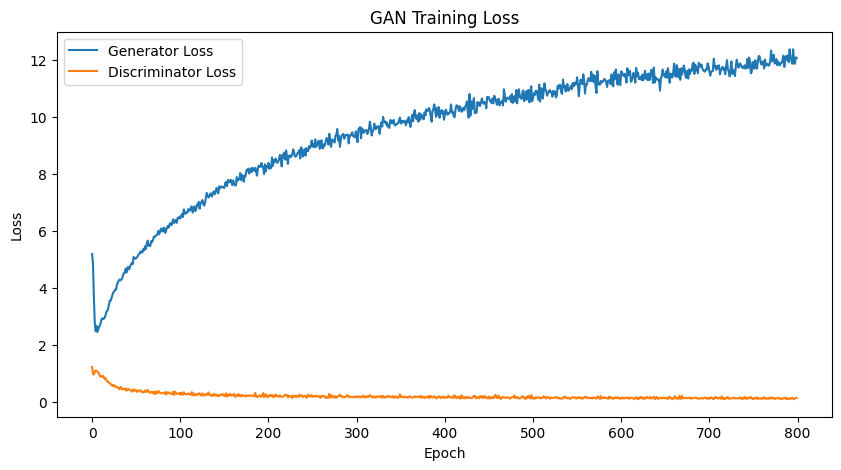

In [ ]:
train_gan(EPOCHS, dataloader)


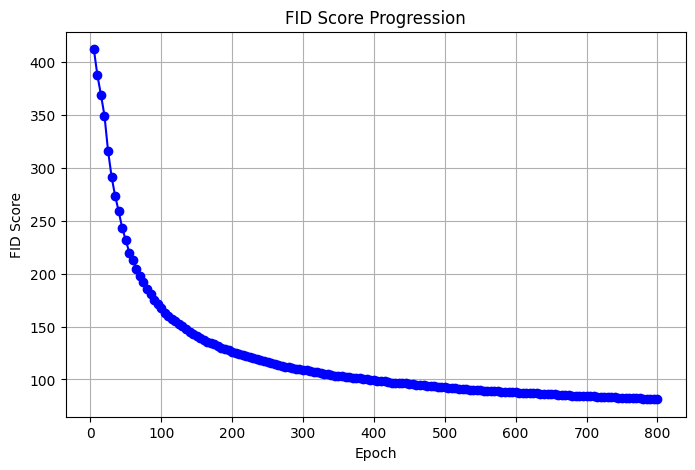

In [130]:

fid_df = pd.DataFrame(fid_scores, columns=["Epoch", "FID Score"])

# Optionally, you can also plot FID scores over epochs
plt.figure(figsize=(8,5))
plt.plot(fid_df["Epoch"], fid_df["FID Score"], marker='o', color='b')
plt.xlabel("Epoch")
plt.ylabel("FID Score")
plt.title("FID Score Progression")
plt.grid(True)
plt.show()

In [131]:
torch.save(generator.state_dict(), "generator.pth")